# Geospatial Analysis of Housing Data (Brasília - DF)

## 🏙️ Context

When we think about **buying or renting a property**, it’s common to consider factors such as **price, location, size, number of bedrooms, bathrooms, and parking spaces**. Often, when browsing real estate websites, we automatically associate the **property value** with the **area where it is located** — especially in Brasília, where neighborhoods like **Asa Sul, Asa Norte, and Jardim Botânico** have very distinct value perceptions.

But does the **price of a property depend only on its physical characteristics**, such as size and number of rooms? Or does **geographical location also play a significant role** in determining its value?

Moreover, an important question arises: could the **presence of certain nearby amenities**, such as **parks, shopping centers, schools, hospitals, or leisure areas**, contribute to **increasing the property’s value**?

In this study, we aim to investigate whether these factors truly manifest in the context of **Brasília’s real estate market**. By the end, we will seek to answer these two fundamental questions and understand **which elements most influence property values** in the capital city.

---

## 🗺️ Step 1: Load the boundaries of Brasília and the real estate dataset

To begin our analysis, we will load **the official geographic boundaries of the Federal District** and **the dataset containing real estate listings in Brasília**.

The **territorial boundaries** will be obtained directly from the **official IBGE repository**, which provides updated municipal shapefiles for all regions of Brazil. This layer will serve as a **spatial reference** to identify which properties are truly located within the administrative limits of the Federal District.
The **real estate data**, on the other hand, were collected from a **real estate listings website** and stored in a CSV file containing information such as price, number of bedrooms, bathrooms, parking spaces, and geographic coordinates (latitude and longitude).

Before moving on to exploration, it’s essential to perform a **thorough data cleaning**, since real estate datasets often contain **incorrect or inconsistent records**. Common issues include:

* Properties with **coordinates outside the Federal District boundaries**;
* Records with **missing values (`NaN`)** in key fields;
* **Unrealistic prices** — either extremely high or low compared to the market average.

To ensure our analysis is accurate, we will follow these steps:

1. **Remove records with missing values** in critical fields such as latitude, longitude, and price;
2. **Convert the dataset into a GeoDataFrame** to enable spatial operations using the coordinates;
3. **Filter only the properties located within the official polygon of the Federal District**, using the IBGE geometry as a spatial mask.

After completing this step, we will have a **clean and geographically consistent dataset**, ready for further analysis — including spatial visualization and exploration of the factors that influence real estate prices in Brasília.


⏱️ Execution started...
📥 Loading Federal District official boundary from IBGE...
✅ Official geographic boundary successfully loaded!


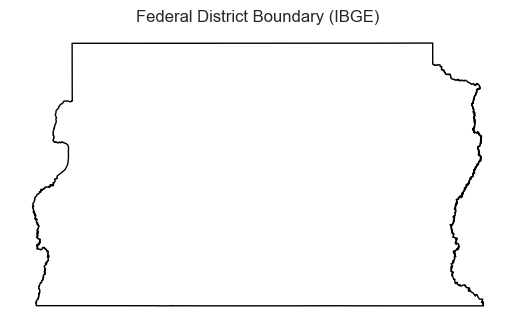

📄 Sample of the original dataset:


,aceita_pets,aquecimento_solar,ar_condicionado,area_lazer,area_servico,area_util,bairro,caracteristicas,cidade,cidade_bairro,...,salao_jogos,sauna,script_lat_long,spa,suites,url,vagas,valor,varanda,vista_livre
0,0,1,0,1,1,194.0,NOROESTE,NaN,BRASÍLIA,BRASÍLIA - NOROESTE,...,1,0,NaN,1,1.0,https://www.dfimoveis.com.br/imovel/lancamento...,1.0,NaN,1,1
1,0,1,0,1,1,600.0,LAGO SUL,NaN,BRASÍLIA,BRASÍLIA - LAGO SUL,...,0,0,NaN,1,5.0,https://www.dfimoveis.com.br/imovel/casa-4-qua...,6.0,15500000.0,1,1
2,0,0,0,0,0,126.0,ASA NORTE,NaN,BRASÍLIA,BRASÍLIA - ASA NORTE,...,0,0,NaN,0,1.0,https://www.dfimoveis.com.br/imovel/apartament...,1.0,1600000.0,0,0
3,1,0,1,0,1,590.0,LAGO SUL,NaN,BRASÍLIA,BRASÍLIA - LAGO SUL,...,0,1,NaN,0,5.0,https://www.dfimoveis.com.br/imovel/casa-4-qua...,4.0,3490000.0,1,0
4,0,1,0,1,1,77.0,NOROESTE,NaN,BRASÍLIA,BRASÍLIA - NOROESTE,...,0,1,NaN,0,2.0,https://www.dfimoveis.com.br/imovel/lancamento...,2.0,NaN,1,0


✅ 13636 records remaining after removing missing coordinates or price.
🏠 13466 properties are located inside the Federal District.
🧹 Unnecessary columns removed.
📌 Remaining columns: ['aceita_pets', 'aquecimento_solar', 'ar_condicionado', 'area_lazer', 'area_servico', 'area_util', 'bairro', 'cond_valor', 'cozinha_com_armarios', 'cozinha_espacosa', 'despensa', 'escritorio', 'gas_canalizado', 'gerador_energia', 'guarita', 'home_theater', 'interfone', 'jardim', 'lavabo', 'lazer_no_pilotis', 'mobiliado', 'pintura_nova', 'piscina', 'piso_porcelanato', 'playground', 'portao_eletronico', 'projeto_iluminacao', 'quadra_poliesportiva', 'quartos', 'sala_ginastica', 'salao_festas', 'salao_gourmet', 'salao_jogos', 'sauna', 'spa', 'suites', 'vagas', 'valor', 'varanda', 'vista_livre', 'geometry']
🧹 Removed 1 invalid neighborhood entries ('selecione').


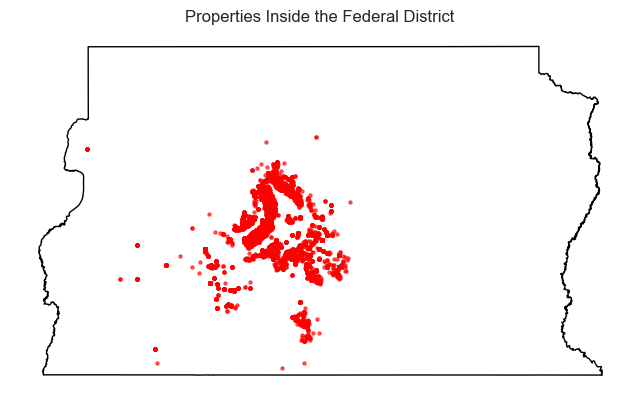

💾 File successfully exported to: REAL_STATE_DATA\properties_DF.geojson
📊 Total exported properties: 13465


In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
start_time = time.time()
print("⏱️ Execution started...")

# ======================================================
# 1️⃣ Load the Official Boundary of the Federal District (IBGE)
# ======================================================

IBGE_URL = (
    "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/"
    "malhas_municipais/municipio_2024/UFs/DF/DF_UF_2024.zip"
)

REAL_ESTATE_CSV = "REAL_STATE_DATA/brasilia.csv"
OUTPUT_DIR = "REAL_STATE_DATA"

print("📥 Loading Federal District official boundary from IBGE...")
df_poly = gpd.read_file(IBGE_URL)
print("✅ Official geographic boundary successfully loaded!")

# Visualize the boundary
df_poly.plot(edgecolor="black", facecolor="none")
plt.title("Federal District Boundary (IBGE)")
plt.axis("off")
plt.show()


# ======================================================
# 2️⃣ Load the Real Estate Dataset
# ======================================================

df = pd.read_csv(REAL_ESTATE_CSV)
print("📄 Sample of the original dataset:")
display(df.head())


# ======================================================
# 3️⃣ Initial Cleaning — Remove Missing Coordinate/Value Records
# ======================================================

df = df.dropna(subset=["latitude", "longitude", "valor"])
print(f"✅ {len(df)} records remaining after removing missing coordinates or price.")


# ======================================================
# 4️⃣ Convert to GeoDataFrame with Point Geometries
# ======================================================

gdf_properties = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)


# ======================================================
# 5️⃣ Filter Properties Inside the Federal District Boundary
# ======================================================

# Merge all polygons into a single geometry
df_union = df_poly.union_all()

mask = gdf_properties.within(df_union)
properties_df = gdf_properties[mask].copy()

print(f"🏠 {len(properties_df)} properties are located inside the Federal District.")


# ======================================================
# 6️⃣ Remove Unnecessary Columns
# ======================================================

columns_to_drop = [
    "longitude", "latitude", "cidade_bairro", "data_coleta", "descricao",
    "caracteristicas", "script_lat_long", "cidade", "imovel", "preco", "url"
]

properties_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

print("🧹 Unnecessary columns removed.")
print("📌 Remaining columns:", list(properties_df.columns))


# ======================================================
# 7️⃣ Remove Invalid Neighborhood Entries (“selecione”)
# ======================================================

if "bairro" in properties_df.columns:
    before = len(properties_df)
    properties_df = properties_df[
        properties_df["bairro"].str.lower() != "selecione"
    ].copy()
    after = len(properties_df)
    print(f"🧹 Removed {before - after} invalid neighborhood entries ('selecione').")
else:
    print("⚠️ Column 'bairro' not found in dataset.")


# ======================================================
# 8️⃣ Visualize Properties Inside the District
# ======================================================

fig, ax = plt.subplots(figsize=(8, 8))
df_poly.plot(ax=ax, color="white", edgecolor="black")
properties_df.plot(ax=ax, markersize=5, color="red", alpha=0.6)
plt.title("Properties Inside the Federal District")
plt.axis("off")
plt.show()


# ======================================================
# 9️⃣ Export the Filtered Dataset
# ======================================================

os.makedirs(OUTPUT_DIR, exist_ok=True)
output_path = os.path.join(OUTPUT_DIR, "properties_DF.geojson")

properties_df.to_file(output_path, driver="GeoJSON")

print(f"💾 File successfully exported to: {output_path}")
print(f"📊 Total exported properties: {len(properties_df)}")



## 📊 Step 2: Exploratory Analysis of Geospatial Data

Now that we have a **clean and geographically consistent real estate dataset**, we can begin the **exploratory data analysis (EDA)**.
At this stage, the goal is to understand the **behavior of property values** in relation to the available variables in the dataset — **without yet considering external factors** such as proximity to parks, schools, or hospitals.

The exploratory analysis aims to answer questions such as:

* What are the **most common price ranges** among properties in Brasília?
* Is there a relationship between the **property value and the number of bedrooms, bathrooms, or parking spaces**?
* Are there **asymmetric distributions** (for example, a few very expensive properties pulling the average upward)?
* How does the **price per square meter** behave across the available records?

Before moving on to more complex models or spatial analyses, it’s important to ensure that the data is well understood and that there are no extreme outliers or inconsistencies that could distort the results.

In this stage, we will:

1. **Visualize descriptive statistics** (mean, median, standard deviation, and quartiles) of the main attributes;
2. **Graphically analyze the distribution of property values** through histograms and boxplots;
3. **Explore correlations** between price and other quantitative variables such as total area, number of bedrooms, bathrooms, and parking spaces;
4. **Calculate the price per square meter**, a useful metric for standardizing comparisons between properties of different sizes.

These analyses will help identify initial patterns, such as possible linear relationships between variables and the general behavior of the real estate market in the Federal District — serving as a foundation for later stages, where we will incorporate the **geographic component** (proximity to services and urban infrastructure).


In [2]:
import dataframe_image as dfi
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------
# 1️⃣ Configure font (supports emoji)
# ------------------------------------------------------
plt.rcParams["font.family"] = "Segoe UI Emoji"

# ------------------------------------------------------
# 2️⃣ Output directory
# ------------------------------------------------------
OUTPUT_DIR_STATS = "ANALISYS_DATA/"
os.makedirs(OUTPUT_DIR_STATS, exist_ok=True)

output_path = os.path.join(OUTPUT_DIR_STATS, "summary_statistics.png")

# ------------------------------------------------------
# 3️⃣ Compute descriptive statistics
# ------------------------------------------------------
desc = properties_df.describe().T

# ------------------------------------------------------
# 4️⃣ Style formatting
# ------------------------------------------------------
desc_styled = (
    desc.style
    .format("{:,.2f}")  # numeric formatting
    .set_caption("📊 Summary Statistics of the Property Dataset")
    .background_gradient(cmap="Blues")  # color gradient
    .set_table_styles(
        [
            {
                "selector": "caption",
                "props": [
                    ("font-size", "16px"),
                    ("font-weight", "bold"),
                    ("text-align", "left"),
                    ("color", "#2E86C1"),
                ],
            },
            {
                "selector": "th",
                "props": [
                    ("background-color", "#1B2631"),
                    ("color", "white"),
                    ("text-align", "center"),
                ],
            },
        ]
    )
)

# ------------------------------------------------------
# 5️⃣ Export styled DataFrame as PNG
# ------------------------------------------------------
dfi.export(desc_styled, output_path, table_conversion="matplotlib")

print(f"✅ Table successfully exported to: {output_path}")

# Display inside notebook (optional)
display(desc_styled)



✅ Table successfully exported to: ANALISYS_DATA/summary_statistics.png


,count,mean,std,min,25%,50%,75%,max
aceita_pets,"13,465.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00
aquecimento_solar,"13,465.00",0.10,0.29,0.00,0.00,0.00,0.00,1.00
ar_condicionado,"13,465.00",0.24,0.42,0.00,0.00,0.00,0.00,1.00
area_lazer,"13,465.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00
area_servico,"13,465.00",0.30,0.46,0.00,0.00,0.00,1.00,1.00
area_util,"13,465.00",725.34,"5,890.17",0.00,75.14,233.40,563.00,"470,178.00"
cond_valor,"7,218.00","1,908.28","39,095.27",0.00,457.25,671.00,"1,106.00","2,100,000.00"
cozinha_com_armarios,"13,465.00",0.26,0.44,0.00,0.00,0.00,1.00,1.00
cozinha_espacosa,"13,465.00",0.19,0.39,0.00,0.00,0.00,0.00,1.00
despensa,"13,465.00",0.14,0.35,0.00,0.00,0.00,0.00,1.00


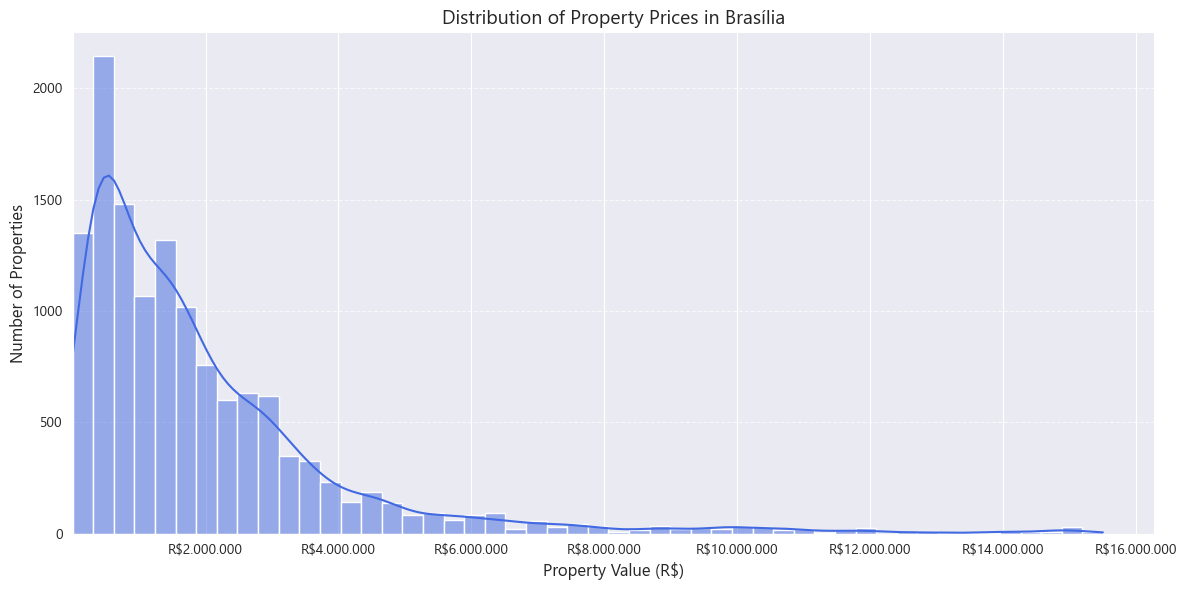

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import pandas as pd

# ------------------------------------------------------
# 1️⃣ Ensure value field is numeric
# ------------------------------------------------------
properties_df["valor"] = pd.to_numeric(properties_df["valor"], errors="coerce")

# Filter invalid or zero values (for visualization only)
filtered_df = properties_df[properties_df["valor"] > 0]

# ------------------------------------------------------
# 2️⃣ Remove extreme outliers (values above 99th percentile)
# ------------------------------------------------------
upper_limit = np.percentile(filtered_df["valor"], 99)
filtered_data = filtered_df[filtered_df["valor"] <= upper_limit]

# Determine minimum value to anchor x-axis
min_value = filtered_data["valor"].min()

# ------------------------------------------------------
# 3️⃣ Create histogram
# ------------------------------------------------------
plt.figure(figsize=(12, 6))

ax = sns.histplot(
    filtered_data["valor"],
    bins=50,
    kde=True,
    color="royalblue"
)

# ------------------------------------------------------
# 4️⃣ Title and labels
# ------------------------------------------------------
plt.title("Distribution of Property Prices in Brasília", fontsize=14, fontweight="bold")
plt.xlabel("Property Value (R$)", fontsize=12)
plt.ylabel("Number of Properties", fontsize=12)

# ------------------------------------------------------
# 5️⃣ Format x-axis values in Brazilian Real (R$)
# ------------------------------------------------------
formatter = mticker.FuncFormatter(
    lambda x, pos: f"R${x:,.0f}".replace(",", ".")
)
ax.xaxis.set_major_formatter(formatter)

# ------------------------------------------------------
# 6️⃣ Additional styling
# ------------------------------------------------------
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlim(left=min_value)
plt.tight_layout()

# ------------------------------------------------------
# 7️⃣ Save figure
# ------------------------------------------------------
plt.savefig(f"{OUTPUT_DIR_STATS}/property_value_distribution.png", dpi=300)
plt.show()


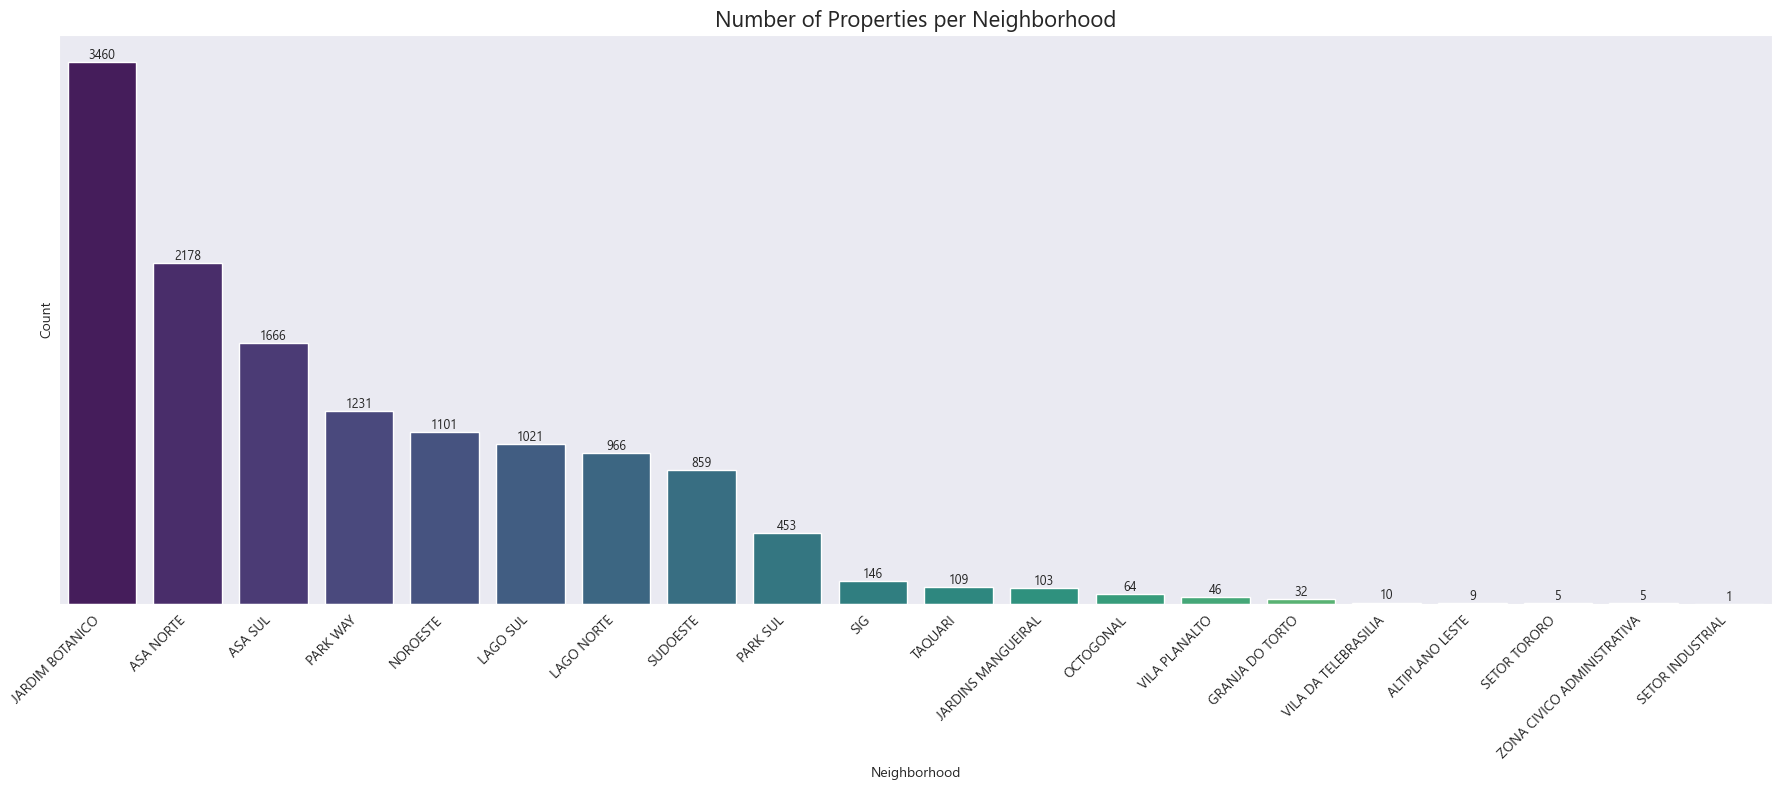

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1️⃣ Ensure the 'valor' column is numeric
# ------------------------------------------------------
properties_df["valor"] = properties_df["valor"].astype(float)

# ------------------------------------------------------
# 2️⃣ Count number of properties per neighborhood
# ------------------------------------------------------
bairro_counts = (
    properties_df["bairro"]
    .value_counts()
    .reset_index(name="count")
    .rename(columns={"index": "bairro"})
)


# Remove duplicate columns if necessary
bairro_counts = bairro_counts.loc[:, ~bairro_counts.columns.duplicated()]

# Sort neighborhoods by descending number of properties
bairro_counts = bairro_counts.sort_values(by="count", ascending=False)

# ------------------------------------------------------
# 3️⃣ Create the bar plot
# ------------------------------------------------------
plt.figure(figsize=(18, 8))

ax = sns.barplot(
    data=bairro_counts,
    x="bairro",
    y="count",
    palette="viridis",
    hue="bairro",
    dodge=False  # Prevent duplicated bars by removing hue separation
)

# ------------------------------------------------------
# 4️⃣ Add value labels above each bar
# ------------------------------------------------------
for i, v in enumerate(bairro_counts["count"]):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom", fontsize=9)

# ------------------------------------------------------
# 5️⃣ Formatting and style
# ------------------------------------------------------
plt.xticks(rotation=45, ha="right")
plt.title("Number of Properties per Neighborhood", fontsize=16, fontweight="bold")
plt.xlabel("Neighborhood")
plt.ylabel("Count")
plt.yticks([])
plt.legend([], [], frameon=False)   # Remove legend (neighborhood names already on x-axis)
plt.tight_layout()

# ------------------------------------------------------
# 6️⃣ Save figure
# ------------------------------------------------------
plt.savefig(f"{OUTPUT_DIR_STATS}/neighborhood_count.png", dpi=300)
plt.show()


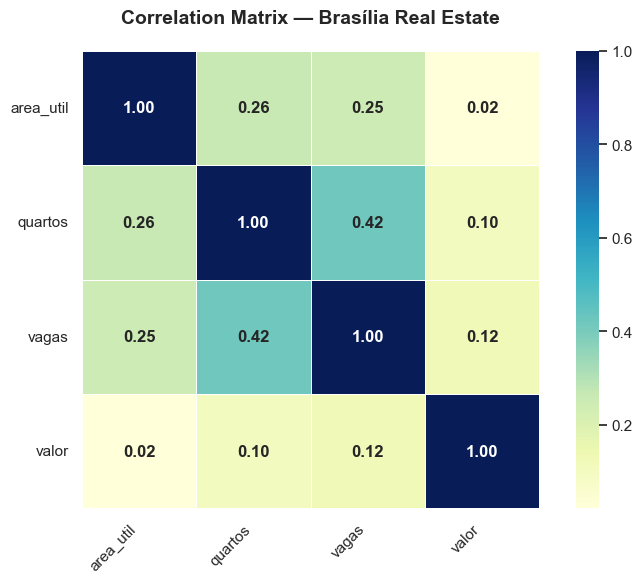

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1️⃣ Select numerical columns for correlation analysis
# ------------------------------------------------------
columns = ["area_util", "quartos", "vagas", "valor"]
corr = properties_df[columns].corr(method="pearson")

# ------------------------------------------------------
# 2️⃣ Configure figure and style
# ------------------------------------------------------
plt.figure(figsize=(8, 6))
sns.set(style="white")

# ------------------------------------------------------
# 3️⃣ Create heatmap with annotations
# ------------------------------------------------------
ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 12, "weight": "bold"},
)

# ------------------------------------------------------
# 4️⃣ Title and final adjustments
# ------------------------------------------------------
plt.title(
    "Correlation Matrix — Brasília Real Estate",
    fontsize=14,
    weight="bold",
    pad=20
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()

# ------------------------------------------------------
# 5️⃣ Save figure
# ------------------------------------------------------
plt.savefig(f"{OUTPUT_DIR_STATS}/corr_matrix.png", dpi=300)

plt.show()


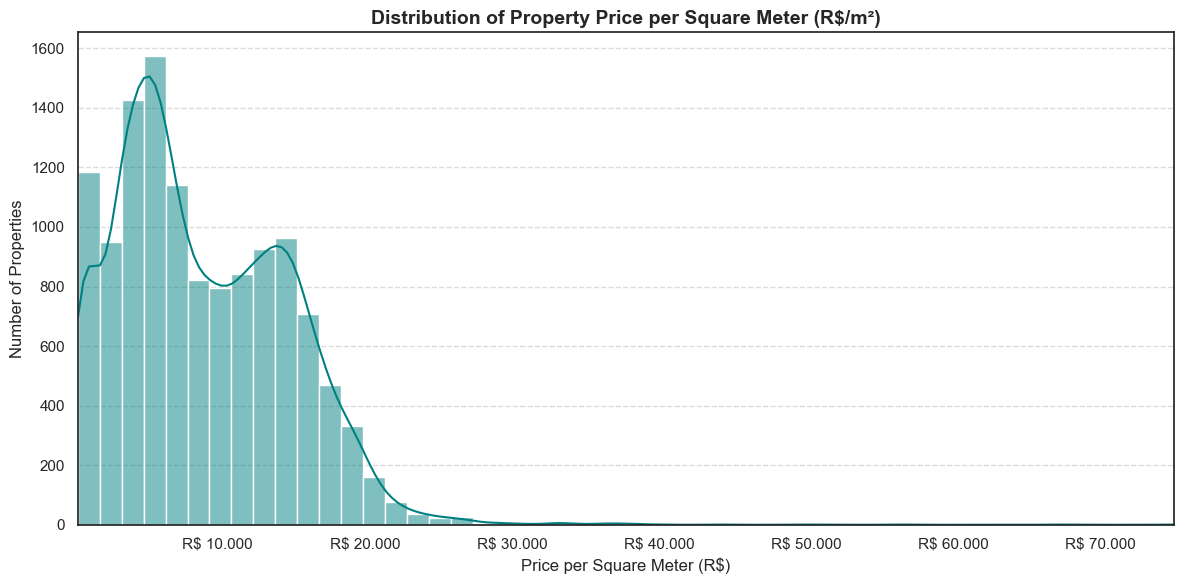

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# ------------------------------------------------------
# 1️⃣ Compute Price per Square Meter
# ------------------------------------------------------
properties_df["preco_m2"] = properties_df["valor"] / properties_df["area_util"]

# Filter out unrealistic values
properties_df = properties_df[
    (properties_df["preco_m2"] > 500) &
    (properties_df["preco_m2"] < 80000)
]

# ------------------------------------------------------
# 2️⃣ Create Histogram
# ------------------------------------------------------
plt.figure(figsize=(12, 6))

ax = sns.histplot(
    properties_df["preco_m2"],
    bins=50,
    kde=True,
    color="teal"
)

# ------------------------------------------------------
# 3️⃣ Format X-axis (Brazilian format with R$ symbol)
# ------------------------------------------------------
formatter = mticker.FuncFormatter(
    lambda x, pos: f"R$ {x:,.0f}".replace(",", ".")
)
ax.xaxis.set_major_formatter(formatter)

# ------------------------------------------------------
# 4️⃣ Labels and Layout
# ------------------------------------------------------
plt.xlim(
    left=properties_df["preco_m2"].min(),
    right=properties_df["preco_m2"].max()
)

plt.title(
    "Distribution of Property Price per Square Meter (R$/m²)",
    fontsize=14,
    fontweight="bold"
)
plt.xlabel("Price per Square Meter (R$)", fontsize=12)
plt.ylabel("Number of Properties", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

# ------------------------------------------------------
# 5️⃣ Save Figure
# ------------------------------------------------------
plt.savefig(f"{OUTPUT_DIR_STATS}/property_price_distribution.png", dpi=300)
plt.show()


#### 💡 Interpretation of Results and Next Steps

From the analyses conducted so far, it is clear that **none of the quantitative variables alone** — such as usable area, number of bedrooms, bathrooms, or parking spaces — are strong enough to fully explain the variation in property values in Brasília. This suggests that **property prices are influenced by more than just physical characteristics**.

One important observation is the presence of **multicollinearity** among some variables — that is, variables that are highly correlated with each other. For instance, the number of bedrooms and the number of suites show a strong positive correlation, indicating that properties with more bedrooms also tend to have more suites. While this makes sense conceptually, such overlap can reduce the model’s ability to isolate the unique impact of each variable on price.

Another key finding concerns the **distribution of property prices**, which is **right-skewed (positively asymmetric)**. This means that a small number of high-priced properties pull the average upward, while most properties are concentrated in lower price ranges. This kind of asymmetry makes simple linear modeling less effective, since linear regression assumes normally distributed residuals.

**Removing Derived Variables to Prevent Data Leakage**

Before training our model to predict real estate prices, we need to apply an important correction to our dataset.

Our goal is to predict the **total property value** using only intrinsic features of the dataset. However, the current dataset includes the column `preco_m2`, which is calculated using the formula:

$$
\text{Price per Square Meter} = \frac{\text{property value}}{\text{usable area}}
$$

This means that `preco_m2` is directly derived from the **property value**—the very variable we want the model to predict.

Keeping this feature in the training set would lead to **data leakage**, because the model would indirectly have access to information that should remain unknown during training. This would artificially inflate the model’s performance and undermine its ability to generalize to unseen data.

Additionally, because this variable is mathematically dependent on other features, its inclusion would introduce **multicollinearity**, harming the model’s stability and interpretability.

To avoid these issues, we will remove the `preco_m2` column from the `properties_df` dataframe and save the corrected dataset for subsequent training.



In [7]:
# ---------------------------------------------
# 1️⃣  Load the dataset
# ---------------------------------------------
input_path = "REAL_STATE_DATA/properties_DF.geojson"
output_path = "REAL_STATE_DATA/properties_DF.geojson"

print("📂 Loading dataset...")
properties_df = gpd.read_file(input_path)
print(f"Dataset loaded successfully with {len(properties_df)} records.")

# ---------------------------------------------
# 2️⃣ Remove the 'preco_m2' column (if present)
# ---------------------------------------------
column_to_remove = "preco_m2"

if column_to_remove in properties_df.columns:
    print(f"🧹 Removing column: {column_to_remove}")
    properties_df = properties_df.drop(columns=[column_to_remove])
else:
    print(f"⚠️ Column '{column_to_remove}' not found. No changes made to columns.")

# ---------------------------------------------
# 3️⃣ Save the cleaned dataset
# ---------------------------------------------
print("💾 Saving cleaned dataset...")
properties_df.to_file(output_path, driver="GeoJSON")

print(f"✅ Dataset saved successfully at: {output_path}")



📂 Loading dataset...
Dataset loaded successfully with 13465 records.
⚠️ Column 'preco_m2' not found. No changes made to columns.
💾 Saving cleaned dataset...
✅ Dataset saved successfully at: REAL_STATE_DATA/properties_DF.geojson


---

## 📊 Step 3: Building Predictive Models for Property Values

These challenges, however, **do not prevent us from building predictive models** that can better capture the complexity of the real estate market. To address this, we will apply three distinct modeling approaches — each with a specific purpose and analytical depth:

1. **Linear Regression Model**
   This model will attempt to predict property values based on a few key variables that are intuitively related to price. The goal is to establish a baseline understanding — even if it may not be fully accurate — of how certain features relate to value.

2. **Multiple Linear Regression (with p-value analysis)**
   In this model, we will include a broader set of variables and analyze their statistical significance through *p-values*. This will allow us to objectively identify which features truly contribute to price prediction and which do not. While we might temporarily exclude some variables with low significance, they will be kept for future verification or different analytical contexts.

3. **Random Forest Regressor**
   Finally, we will use a Random Forest model to capture **nonlinear relationships and complex interactions** between variables. This algorithm is robust against asymmetry, outliers, and multicollinearity, making it well-suited for the irregular patterns of the real estate market. It will also help identify which variables are most influential in determining property prices.

To evaluate the performance of each model, we will use standardized metrics:

* **MAE (Mean Absolute Error)**
* **RMSE (Root Mean Squared Error)**
* **R² (Coefficient of Determination)**

These metrics will allow us to **compare accuracy consistently** and determine which approach performs best in predicting property values in Brasília.
By using these benchmarks, we aim to make **data-driven, coherent, and transparent decisions** about which modeling strategy offers the best balance between interpretability and predictive power — a critical step toward understanding and forecasting property prices in the Federal District.

#### Model 1: Linear Regression Model — Evaluating Property Values

📈 Model Evaluation Metrics:
Mean Absolute Error (MAE): R$ 1,467,959.89
Root Mean Squared Error (RMSE): R$ 3,141,408.94
R² Score: 0.2402


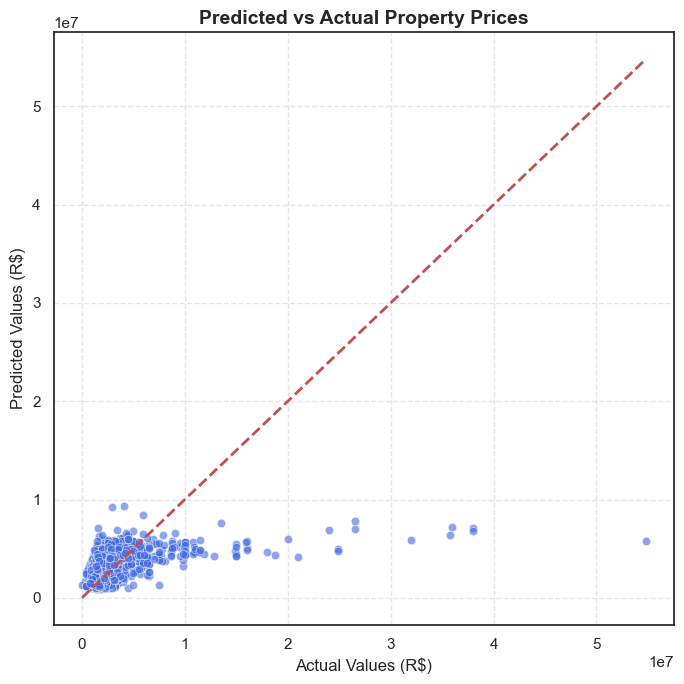


💡 Feature Importance (Linear Regression Coefficients):


,Feature,Coefficient
2,suites,1.127948e+06
3,vagas,5.169994e+05
0,area_util,4.515361e+05
4,pintura_nova,9.686814e+04
1,quartos,-1.519263e+05


In [8]:
# ======================================================
# 🧠 Linear Regression Model — Evaluating Property Prices
# ======================================================

import os
import random
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------
# 1️⃣ Reproducibility and Output Setup
# ------------------------------------------------------
random.seed(42)

OUTPUT_DIR_MODELS = "MODEL_RESULTS/"
os.makedirs(OUTPUT_DIR_MODELS, exist_ok=True)

# ------------------------------------------------------
# 2️⃣ Feature Selection
# ------------------------------------------------------
# These features must exist in `properties_df`
features = ["area_util", "quartos", "suites", "vagas", "pintura_nova"]
target = "valor"

# Clean dataset (remove missing values)
data_model = properties_df[features + [target]].dropna()

# Separate variables
X = data_model[features]
y = data_model[target]

# ------------------------------------------------------
# 3️⃣ Feature Scaling
# ------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------
# 4️⃣ Train/Test Split
# ------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------
# 5️⃣ Train Linear Regression Model
# ------------------------------------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# ------------------------------------------------------
# 6️⃣ Predictions
# ------------------------------------------------------
y_pred = model.predict(X_test)

# ------------------------------------------------------
# 7️⃣ Performance Metrics
# ------------------------------------------------------
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📈 Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): R$ {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): R$ {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

# ------------------------------------------------------
# 8️⃣ Actual vs Predicted Plot
# ------------------------------------------------------
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="royalblue")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--", lw=2
)

plt.xlabel("Actual Values (R$)", fontsize=12)
plt.ylabel("Predicted Values (R$)", fontsize=12)
plt.title("Predicted vs Actual Property Prices", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig(
    f"{OUTPUT_DIR_MODELS}/linear_regression_actual_vs_predicted.png",
    dpi=300
)
plt.show()

# ------------------------------------------------------
# 9️⃣ Display Feature Coefficients
# ------------------------------------------------------
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\n💡 Feature Importance (Linear Regression Coefficients):")
display(coef_df)


#### Model 2: Multiple Linear Regression with p-value Analysis

In [9]:
# ======================================================
# 🧠 MULTIPLE LINEAR REGRESSION — WITH P-VALUE ANALYSIS
# ======================================================

import statsmodels.api as sm

# ------------------------------------------------------
# 1️⃣ Select Explanatory Variables
# ------------------------------------------------------
# Excludes categorical ('bairro') and geometric ('geometry') columns.

columns = [
    "aceita_pets", "aquecimento_solar", "ar_condicionado", "area_lazer",
    "area_servico", "area_util", "cond_valor", "cozinha_com_armarios",
    "cozinha_espacosa", "despensa", "escritorio", "gas_canalizado",
    "gerador_energia", "guarita", "home_theater", "interfone", "jardim",
    "lavabo", "lazer_no_pilotis", "mobiliado", "pintura_nova", "piscina",
    "piso_porcelanato", "playground", "portao_eletronico",
    "projeto_iluminacao", "quadra_poliesportiva", "quartos",
    "sala_ginastica", "salao_festas", "salao_gourmet", "salao_jogos",
    "sauna", "spa", "suites", "vagas", "varanda", "vista_livre",
    "preco_m2"
]

# ------------------------------------------------------
# 2️⃣ Validate Columns and Prepare Data
# ------------------------------------------------------
# Keep only columns that actually exist in the dataset
available_cols = [c for c in columns if c in properties_df.columns]

# Build dataset and drop rows with missing values
data = properties_df[available_cols + ["valor"]].dropna()

# Dependent variable (target)
y = data["valor"]

# Independent variables (predictors)
X = data[available_cols]

# Add intercept term for regression
X = sm.add_constant(X)

# ------------------------------------------------------
# 3️⃣ Fit the OLS Model
# ------------------------------------------------------
model = sm.OLS(y, X).fit()

# ------------------------------------------------------
# 4️⃣ Display Full Summary
# ------------------------------------------------------
print(model.summary())

# ------------------------------------------------------
# 5️⃣ Export Model Summary
# ------------------------------------------------------
output_file = f"{OUTPUT_DIR_MODELS}/OLS_Model_Summary.txt"

with open(output_file, "w", encoding="utf-8") as f:
    f.write(model.summary().as_text())

print(f"📄 Model summary saved to: {output_file}")


                            OLS Regression Results                            
Dep. Variable:                  valor   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     51.27
Date:                Sat, 15 Nov 2025   Prob (F-statistic):          8.33e-307
Time:                        17:37:30   Log-Likelihood:                -59255.
No. Observations:                3797   AIC:                         1.186e+05
Df Residuals:                    3758   BIC:                         1.188e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.509e+05 

#### Model 3: Random Forest Regressor — Predicting Property Values


📊 Model Evaluation
MAE  (Mean Absolute Error):       R$ 484,063.94
RMSE (Root Mean Square Error):    R$ 897,321.94
R²   (Coefficient of Determination): 0.700


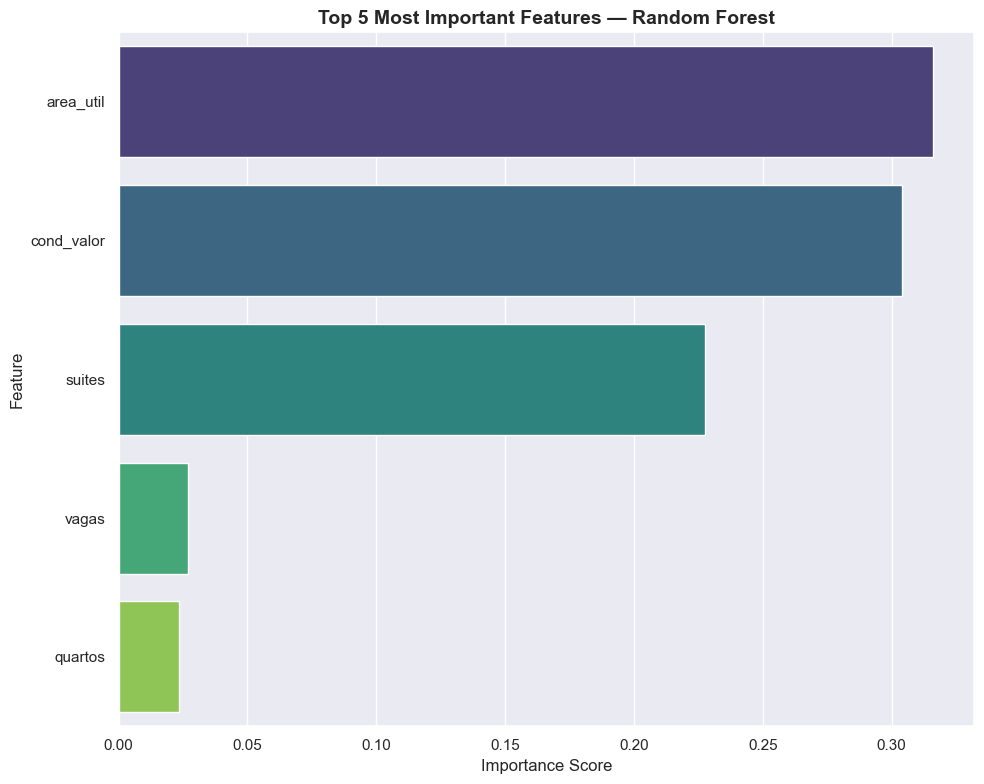


📁 Feature importance plot saved to: MODEL_RESULTS//randomforest_feature_importance.png


In [10]:
# ======================================================
# 🌲 RANDOM FOREST REGRESSOR — PROPERTY VALUE PREDICTION
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# ------------------------------------------------------
# 1️⃣ Select Predictive Features
# ------------------------------------------------------
# Excludes geometry and text columns; ensures all exist
features = [
    "aceita_pets", "aquecimento_solar", "ar_condicionado", "area_lazer",
    "area_servico", "area_util", "cond_valor", "cozinha_com_armarios",
    "cozinha_espacosa", "despensa", "escritorio", "gas_canalizado",
    "gerador_energia", "guarita", "home_theater", "interfone", "jardim",
    "lavabo", "lazer_no_pilotis", "mobiliado", "pintura_nova", "piscina",
    "piso_porcelanato", "playground", "portao_eletronico",
    "projeto_iluminacao", "quadra_poliesportiva", "quartos",
    "sala_ginastica", "salao_festas", "salao_gourmet", "salao_jogos",
    "sauna", "spa", "suites", "vagas", "varanda", "vista_livre",
    "preco_m2"
]

# Filter only features that exist in the dataset
available_features = [f for f in features if f in properties_df.columns]

# Ensure no missing values and include target variable
df_model = properties_df[available_features + ["valor"]].dropna()

X = df_model[available_features]
y = df_model["valor"]

# ------------------------------------------------------
# 2️⃣ Train/Test Split
# ------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# ------------------------------------------------------
# 3️⃣ Train Random Forest Model
# ------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

# ------------------------------------------------------
# 4️⃣ Evaluate Model Performance
# ------------------------------------------------------
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation")
print(f"MAE  (Mean Absolute Error):       R$ {mae:,.2f}")
print(f"RMSE (Root Mean Square Error):    R$ {rmse:,.2f}")
print(f"R²   (Coefficient of Determination): {r2:.3f}")

# ------------------------------------------------------
# 5️⃣ Compute Feature Importance
# ------------------------------------------------------
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# ------------------------------------------------------
# 6️⃣ Plot Top 5 Most Important Features
# ------------------------------------------------------
plt.figure(figsize=(10, 8))

sns.barplot(
    data=importances.head(5),
    x="Importance",
    y="Feature",
    palette="viridis",
    hue="Feature"
)

plt.title("Top 5 Most Important Features — Random Forest", fontsize=14, fontweight="bold")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.legend([], [], frameon=False)  # Remove redundant legend
plt.tight_layout()

output_fig = f"{OUTPUT_DIR_MODELS}/randomforest_feature_importance.png"
plt.savefig(output_fig, dpi=300, bbox_inches="tight")
plt.show()

print(f"\n📁 Feature importance plot saved to: {output_fig}")




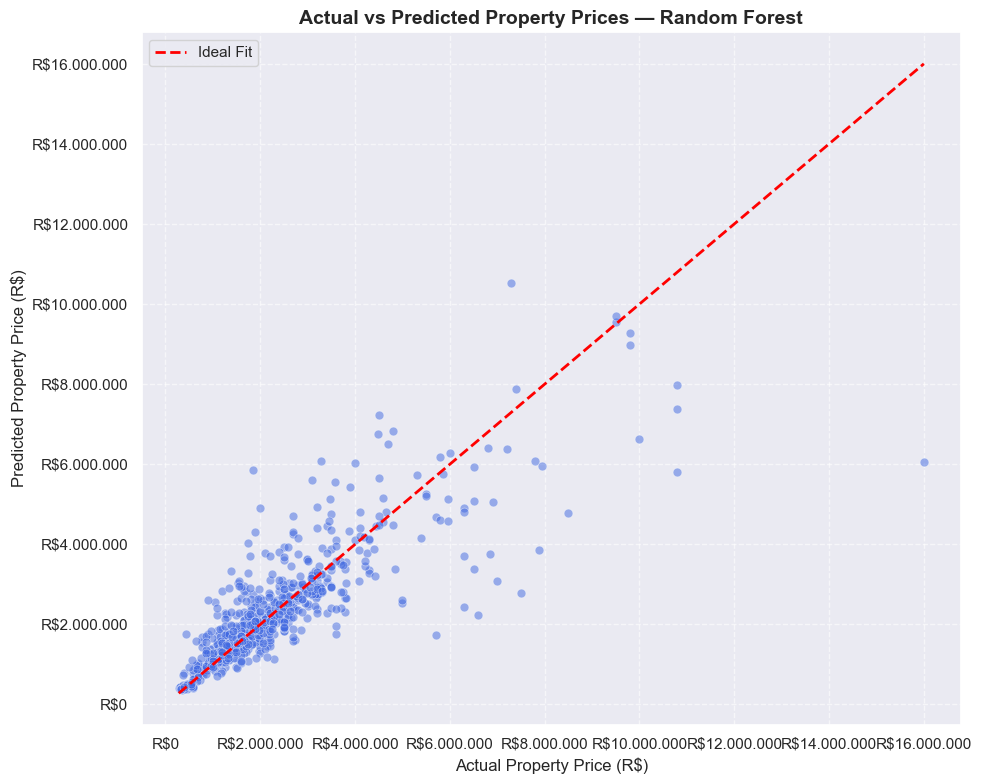

📁 Plot saved to: MODEL_RESULTS//randomforest_actual_vs_predicted.png


In [11]:
# ======================================================
# 📊 ACTUAL VS PREDICTED PLOT — RANDOM FOREST MODEL
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# ------------------------------------------------------
# 1️⃣ Scatter Plot — Actual vs Predicted
# ------------------------------------------------------

plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=y_test,
    y=y_pred,
    alpha=0.5,
    color="royalblue",
    s=40
)

# ------------------------------------------------------
# 2️⃣ Ideal Reference Line (y = x)
# ------------------------------------------------------

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Ideal Fit"
)

# ------------------------------------------------------
# 3️⃣ Titles and Labels
# ------------------------------------------------------

plt.title("Actual vs Predicted Property Prices — Random Forest", fontsize=14, fontweight="bold")
plt.xlabel("Actual Property Price (R$)", fontsize=12)
plt.ylabel("Predicted Property Price (R$)", fontsize=12)

# ------------------------------------------------------
# 4️⃣ Axis Formatting (Brazilian Real)
# ------------------------------------------------------

real_formatter = FuncFormatter(lambda x, _: f"R${x:,.0f}".replace(",", "."))
plt.gca().xaxis.set_major_formatter(real_formatter)
plt.gca().yaxis.set_major_formatter(real_formatter)

# ------------------------------------------------------
# 5️⃣ Grid and Final Layout
# ------------------------------------------------------

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# ------------------------------------------------------
# 6️⃣ Save Figure
# ------------------------------------------------------

output_path = f"{OUTPUT_DIR_MODELS}/randomforest_actual_vs_predicted.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()

print(f"📁 Plot saved to: {output_path}")



---

### 📊 **Model Comparison — Property Value Prediction (Brasília)**

| Model                                |      MAE (R\$) |     RMSE (R\$) |  R² Score | Interpretation                                                               |
|--------------------------------------|---------------:|---------------:| :-------: | ---------------------------------------------------------------------------- |
| **Linear Regression Model**          |   1,467,959.89 |   3,141,408.94 |   0.2402  | Baseline model — captures only broad trends; weak predictive power.          |
| **Multiple Linear Regression (OLS)** |              — |              — |   0.341   | Improves explanatory power; identifies statistically significant predictors. |
| **Random Forest Regressor**          | **484,063.94** | **897,321.94** | **0.700** | Strong predictive performance; captures nonlinear patterns effectively.      |

---

### 💡 **Insights from the Model Comparison**

#### 🔹 **Multiple Linear Regression (OLS)**

The OLS model shows clear improvement over the simple regression, increasing the R² from **0.24 → 0.34**.
It identifies important predictors such as:

* **usable area (area_util)**
* **number of suites (suites)**
* **parking spaces (vagas)**
* amenities like **piscina**, **home_theater**, **ar_condicionado**

However, it still suffers from:

* **multicollinearity** (condition number ≈ 4.28e+05)
* linear assumptions that limit predictive performance
* residuals showing strong deviations from normality (high skewness and kurtosis)

#### 🔹 **Random Forest Regressor**

The Random Forest model greatly outperforms the linear models:

* **MAE reduced by ~67%** compared to OLS/Simple Regression
* **R² = 0.700**, meaning it explains **70% of price variation**
* Excels at **capturing nonlinear interactions** between property features

The trade-off is reduced interpretability, as nonlinear ensemble models are not as transparent as OLS.

#### 🔹 **Linear Regression Model**

This baseline model shows the limitations of using only a handful of intrinsic variables.
With R² ≈ **0.24**, it captures only superficial price patterns.

---

### 🏠 **Conclusion: What Really Defines Property Prices in Brasília?**

From the analyses carried out, we can conclude that **property prices in Brasília are not determined solely by physical characteristics**, such as usable area, number of bedrooms, suites, or parking spaces.

The linear regression models showed that, although these intrinsic features do influence prices, **they account for only a portion of the total variability** in property values. This indicates that factors beyond the internal attributes of the units play a substantial role in shaping real estate prices.

The **Random Forest Regressor** demonstrated **good overall performance**, with noticeably lower error rates compared to the linear models and a considerably higher R² score. However, it is important to highlight that this model — in the way it was applied — **did not explicitly incorporate geographic information**. It relied exclusively on tabular features, without considering coordinates, neighborhood effects, or spatial proximity measures.

Thus, even though the Random Forest was able to capture more complex interactions involving features like usable area, number of suites, swimming pool, or finish quality, **it still lacked awareness of where each property is located** — a key factor in how real estate markets behave.

There is an **indirect geographical influence** in the dataset, given that more expensive properties tend to be located in higher-value areas of the city. This spatial pattern is implicitly reflected in some of the property’s internal features.

In short, the value of a property **depends not only on what the property is, but also on where it is situated**. Proximity to high-value neighborhoods, access to services, infrastructure quality, environmental conditions, and even perceived prestige or safety strongly affect market prices — yet none of these elements have been formally integrated into the current model.

The next step will be to **incorporate explicit geographic and contextual variables** — such as latitude and longitude, distance to the city center, and proximity to schools, hospitals, parks, and transit stations. Including these spatial dimensions will help us better capture **how location shapes property values** and reveal the broader urban dynamics driving Brasília’s real estate market.


---


## 🗺️ Step 4: Adding Geospatial Features to the Model

So far, we’ve reached **partial answers** to our main questions. To move forward, we need to include **geospatial variables** in our predictive model to better understand what truly drives property prices in Brasília.

The next step is to **load new datasets** containing the **locations of key points of interest**, such as hospitals, schools, parks, and shopping centers. By incorporating these spatial features, we’ll be able to analyze whether **proximity to such amenities has a measurable impact on property values**.

We expect that adding these new variables will allow us to **draw stronger and more comprehensive conclusions**, providing a clearer understanding of how **location and accessibility** shape real estate prices in the Federal District.



#### 🌍 Downloading the Required Geospatial Data

To build our geospatial database, we first need to download **OpenStreetMap (OSM) data** for the **Central-West region of Brazil**, which includes the Federal District. These data will provide detailed information on roads, buildings, green areas, and other urban features that may influence housing prices.

We will also download **specific datasets for Brasília’s metro and BRT systems**, as access to public transportation is a crucial factor that can strongly affect property values.



In [12]:
# ======================================================
# 🌍 DOWNLOAD AND EXTRACT OSM DATA — CENTRO-OESTE REGION
# ======================================================

import requests
import zipfile
import os

# ------------------------------------------------------
# 1️⃣ Output Directory
# ------------------------------------------------------

OUTPUT_DIR_GEO = "GEO_DATA"
os.makedirs(OUTPUT_DIR_GEO, exist_ok=True)

# ------------------------------------------------------
# 2️⃣ OSM Source URL (Geofabrik)
# ------------------------------------------------------

OSM_URL = (
    "https://download.geofabrik.de/south-america/brazil/"
    "centro-oeste-251111-free.shp.zip"
)

# File paths
ZIP_PATH = os.path.join(OUTPUT_DIR_GEO, "centro-oeste_OSM.zip")
EXTRACT_PATH = OUTPUT_DIR_GEO

# ------------------------------------------------------
# 3️⃣ Download OSM ZIP Package
# ------------------------------------------------------

print("⬇️ Downloading OSM data for the Centro-Oeste region...")
response = requests.get(OSM_URL, stream=True)

# Save ZIP file incrementally (safe for large files)
with open(ZIP_PATH, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            file.write(chunk)

print("✅ Download completed!")

# ------------------------------------------------------
# 4️⃣ Extract ZIP Contents
# ------------------------------------------------------

print("📦 Extracting files...")
with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

# ------------------------------------------------------
# 5️⃣ Remove ZIP After Extraction
# ------------------------------------------------------

os.remove(ZIP_PATH)
print("🧹 ZIP file removed after extraction.")

print(f"🎉 OSM data for the Centro-Oeste region is ready in the '{OUTPUT_DIR_GEO}' folder!")

⬇️ Downloading OSM data for the Centro-Oeste region...
✅ Download completed!
📦 Extracting files...
🧹 ZIP file removed after extraction.
🎉 OSM data for the Centro-Oeste region is ready in the 'GEO_DATA' folder!


In [13]:
# ===============================================================
# 🚉 DOWNLOAD AND SAVE SUBWAY & BRT GEOSPATIAL LAYERS (BRASÍLIA)
# ===============================================================

import geopandas as gpd
import os

# ---------------------------------------------------------------
# 1️⃣ Output Directory
# ---------------------------------------------------------------

OUTPUT_DIR_GEO = "GEO_DATA"
os.makedirs(OUTPUT_DIR_GEO, exist_ok=True)

# ---------------------------------------------------------------
# 2️⃣ Source URLs — ArcGIS Hub (GeoJSON Download Endpoints)
# ---------------------------------------------------------------

URL_METRO = (
    "https://hub.arcgis.com/api/v3/datasets/92e10066030f40d49059830656ba67a9_0/"
    "downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
)

URL_BRT = (
    "https://hub.arcgis.com/api/v3/datasets/1dabe88927e84464bf62d928b1972ed5_2/"
    "downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
)

# Output file paths (Shapefiles)
METRO_PATH = os.path.join(OUTPUT_DIR_GEO, "metro_brasilia.shp")
BRT_PATH = os.path.join(OUTPUT_DIR_GEO, "brt_brasilia.shp")

# ---------------------------------------------------------------
# 3️⃣ Download Metro Layer
# ---------------------------------------------------------------

print("⬇️ Downloading Brasília Subway (Metrô) data...")
gdf_metro = gpd.read_file(URL_METRO)
print(f"✅ Subway data loaded successfully — {len(gdf_metro)} feature(s) found.")

# ---------------------------------------------------------------
# 4️⃣ Download BRT Layer
# ---------------------------------------------------------------

print("⬇️ Downloading Brasília BRT data...")
gdf_brt = gpd.read_file(URL_BRT)
print(f"✅ BRT data loaded successfully — {len(gdf_brt)} feature(s) found.")

# ---------------------------------------------------------------
# 5️⃣ Save Layers as Shapefiles
# ---------------------------------------------------------------

gdf_metro.to_file(METRO_PATH, driver="ESRI Shapefile")
gdf_brt.to_file(BRT_PATH, driver="ESRI Shapefile")

print("\n💾 Files successfully saved in the 'GEO_DATA' directory:")
print(f"   • Metrô: {METRO_PATH}")
print(f"   • BRT:   {BRT_PATH}")

print("\n🎉 Download & export process completed successfully!")

⬇️ Downloading Brasília Subway (Metrô) data...
✅ Subway data loaded successfully — 29 feature(s) found.
⬇️ Downloading Brasília BRT data...
✅ BRT data loaded successfully — 10 feature(s) found.

💾 Files successfully saved in the 'GEO_DATA' directory:
   • Metrô: GEO_DATA\metro_brasilia.shp
   • BRT:   GEO_DATA\brt_brasilia.shp

🎉 Download & export process completed successfully!


### 🗺️ Delimiting the Area of Interest — Brasília

Now that we have the **official boundary polygon of the Federal District**, we can use it to **clip (cut)** all geospatial layers — including data from **OpenStreetMap (OSM)**, the **Brasília Metro**, and the **BRT system**.

This step ensures that our analysis remains **focused exclusively on the area of interest**, removing any features located outside the boundaries of the Federal District. By doing so, we reduce noise, improve processing efficiency, and maintain spatial consistency across all datasets.

Finally, we will **save the clipped layers as new Shapefiles**, which will later be used in our **spatial analysis** and **predictive modeling** steps.

This process guarantees that every dataset — roads, transport lines, and other urban elements — aligns perfectly within the same geographic extent, forming a solid foundation for accurate and meaningful geospatial insights.


💡 **Spoiler:** The final unified geospatial dataset will be saved as a **GeoPackage file (.gpkg)** — a more efficient and modern format that ensures full compatibility with GIS software. Otherwise, we would need to export multiple shapefiles, one for each geometry type (points, lines, and polygons). After some trial and error, it became clear that exporting everything into a single GeoPackage is a much better solution.

Another important step in this process is handling the **"FID" column**, which often appears in shapefiles. This field is automatically generated by GIS software and can cause conflicts when merging multiple layers. Therefore, during the clipping and unification process, we’ll make sure to remove or rename this column to prevent any issues later on.




In [14]:
# ===============================================================
# 🗺️ MERGE, CLIP, AND EXPORT ALL GEOSPATIAL LAYERS (Brasília - DF)
# ===============================================================

import geopandas as gpd
import pandas as pd
import os
import shutil

# ===============================================================
# 1️⃣ Directories
# ===============================================================

GEO_DIR = "GEO_DATA"
OUTPUT_DIR = "GEO_DATA_FILE"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ===============================================================
# 2️⃣ Load Official Boundary of Distrito Federal
# ===============================================================

print("📍 Loading official boundary of Distrito Federal...")

DF_POLY_URL = (
    "https://geoftp.ibge.gov.br/organizacao_do_territorio/"
    "malhas_territoriais/malhas_municipais/municipio_2024/UFs/DF/DF_UF_2024.zip"
)

df_boundary = gpd.read_file(DF_POLY_URL).to_crs("EPSG:4326")

print(f"✅ Boundary loaded successfully — {len(df_boundary)} feature(s) found.")


# ===============================================================
# 3️⃣ Load Geospatial Layers
# ===============================================================

layers = {
    "buildings": gpd.read_file(f"{GEO_DIR}/gis_osm_buildings_a_free_1.shp"),
    "pois": gpd.read_file(f"{GEO_DIR}/gis_osm_pois_free_1.shp"),
    "pofw_a": gpd.read_file(f"{GEO_DIR}/gis_osm_pofw_a_free_1.shp"),
    "places": gpd.read_file(f"{GEO_DIR}/gis_osm_places_free_1.shp"),
    "landuse": gpd.read_file(f"{GEO_DIR}/gis_osm_landuse_a_free_1.shp"),
    "natural": gpd.read_file(f"{GEO_DIR}/gis_osm_natural_free_1.shp"),
    "natural_a": gpd.read_file(f"{GEO_DIR}/gis_osm_natural_a_free_1.shp"),
    "transport": gpd.read_file(f"{GEO_DIR}/gis_osm_transport_free_1.shp"),
    "transport_a": gpd.read_file(f"{GEO_DIR}/gis_osm_transport_a_free_1.shp"),
    "metro": gpd.read_file(f"{GEO_DIR}/metro_brasilia.shp"),
    "brt": gpd.read_file(f"{GEO_DIR}/brt_brasilia.shp"),
}


# ===============================================================
# 4️⃣ Assign missing fclass values
# ===============================================================

layers["metro"]["fclass"] = "subway_station"
layers["brt"]["fclass"] = "brt_station"


# ===============================================================
# 5️⃣ Clip Each Layer to DF Boundary
# ===============================================================

TARGET_CRS = "EPSG:4326"
combined_layers = []

print("✂️ Clipping all layers to DF boundary...")

for name, layer in layers.items():

    # Reproject if needed
    if layer.crs != TARGET_CRS:
        layer = layer.to_crs(TARGET_CRS)

    try:
        clipped = gpd.clip(layer, df_boundary)
        clipped = clipped.loc[~clipped.geometry.is_empty]  # Remove empty geometries
        clipped["source"] = name  # Track origin layer

        # Avoid conflicts with column named "FID"
        clipped = clipped.rename(columns=lambda c: f"fid_{c}" if c.lower() == "fid" else c)

        combined_layers.append(clipped)
        print(f"✅ {name} clipped — {len(clipped)} features kept.")

    except Exception as e:
        print(f"⚠️ Skipped {name} due to error: {e}")


# ===============================================================
# 6️⃣ Merge All Layers
# ===============================================================

gdf_unified = pd.concat(combined_layers, ignore_index=True)

# Drop duplicate or conflicting columns
gdf_unified = gdf_unified.loc[:, ~gdf_unified.columns.duplicated()]

if "FID" in gdf_unified.columns or "fid" in gdf_unified.columns:
    cols_to_drop = [c for c in gdf_unified.columns if c.lower() == "fid"]
    gdf_unified = gdf_unified.drop(columns=cols_to_drop)

print(f"\n📊 Total combined features: {len(gdf_unified)}")


# ===============================================================
# 7️⃣ Export to GeoPackage
# ===============================================================

output_path = os.path.join(OUTPUT_DIR, "DF_geodata_unified.gpkg")

print("\n💾 Exporting unified GeoPackage...")
gdf_unified.to_file(output_path, driver="GPKG")

print(f"✅ GeoPackage successfully saved to: {output_path}")


# ===============================================================
# 8️⃣ Remove Original Folder
# ===============================================================

DELETE_OLD = True

if DELETE_OLD and os.path.exists(GEO_DIR):
    shutil.rmtree(GEO_DIR)
    print(f"🧹 Old directory '{GEO_DIR}' deleted.")

print("\n🎉 Process completed successfully!")

📍 Loading official boundary of Distrito Federal...
✅ Boundary loaded successfully — 1 feature(s) found.
✂️ Clipping all layers to DF boundary...
✅ buildings clipped — 36793 features kept.
✅ pois clipped — 8530 features kept.
✅ pofw_a clipped — 412 features kept.
✅ places clipped — 209 features kept.
✅ landuse clipped — 12105 features kept.
✅ natural clipped — 4662 features kept.
✅ natural_a clipped — 2 features kept.
✅ transport clipped — 1664 features kept.
✅ transport_a clipped — 143 features kept.
✅ metro clipped — 29 features kept.
✅ brt clipped — 10 features kept.

📊 Total combined features: 64559

💾 Exporting unified GeoPackage...
✅ GeoPackage successfully saved to: GEO_DATA_FILE\DF_geodata_unified.gpkg
🧹 Old directory 'GEO_DATA' deleted.

🎉 Process completed successfully!


## 🗺️ Visualizing the Geospatial Base for the Federal District

Now that we’ve built our geospatial base for the Federal District, let’s load the shapefiles saved in the previous step and visualize them with a clear legend showing the main layers available from **OpenStreetMap (OSM)** for the region.

A quick **spoiler** before we start: in the OSM dataset, you’ll notice that many layers come in pairs — some ending with “_a” and others without.

* Layers ending with **“_a”** represent **polygonal areas**, such as parks, lakes, or land-use zones.
* Layers **without “_a”** usually represent **lines or points**, like roads, buildings, or points of interest (POIs).

When visualizing the data, it’s important to understand these geometry types to correctly interpret the spatial information. To simplify our map, we’ll **merge layers with the same theme but different geometries** (for example, `natural` and `natural_a` will be combined into a single “Natural Areas” layer).

This approach will give us a **cleaner and more intuitive legend**, making the visualization clearer and more informative. As a result, we’ll have a complete geospatial map of the Federal District — it might look a bit crowded, but that’s a good sign: it means we now have **a rich spatial dataset** to work with in the next stages, where we’ll uncover valuable insights about **how urban space influences the real estate market in Brasília**.

📂 Loading unified GeoPackage...
✅ File loaded successfully — 64559 total features.


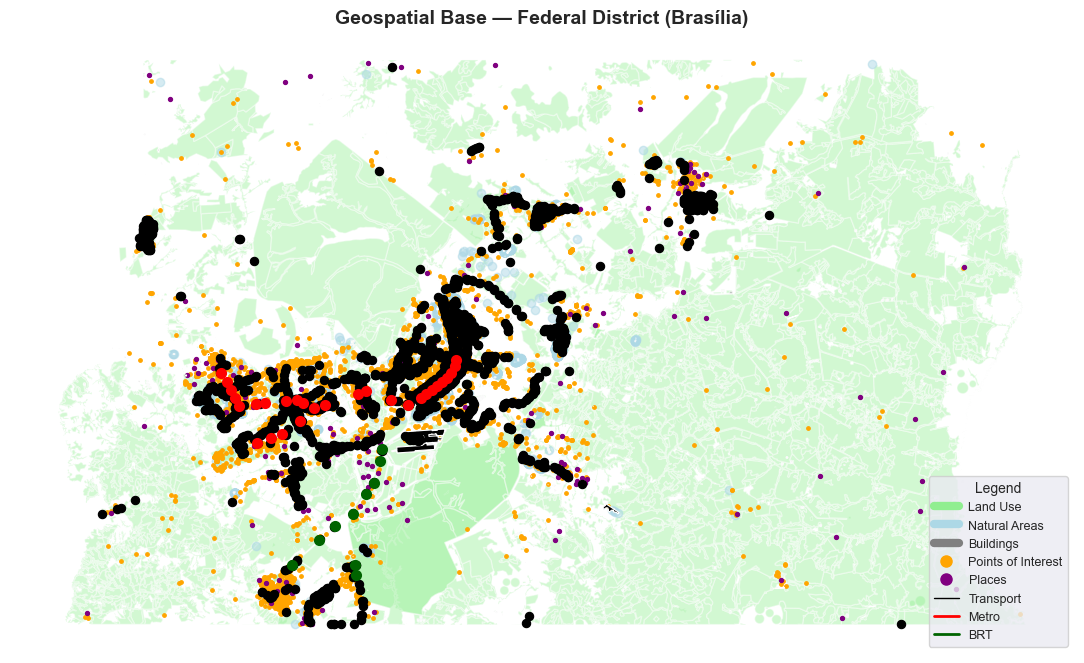

📸 Map exported successfully to: GEO_DATA_FILE/DF_geospatial_base.png


In [15]:
# ======================================================
# 🗺️ VISUALIZING THE GEOSPATIAL BASE — FEDERAL DISTRICT
# ======================================================

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ===============================================================
# 1️⃣ Path to the Unified GeoPackage
# ===============================================================

gpkg_path = f"{OUTPUT_DIR}/DF_geodata_unified.gpkg"

print("📂 Loading unified GeoPackage...")
gdf_unified = gpd.read_file(gpkg_path)
print(f"✅ File loaded successfully — {len(gdf_unified)} total features.")

# ===============================================================
# 2️⃣ Separate Layers by Source Attribute
# ===============================================================

layers = {
    "Buildings": gdf_unified[gdf_unified["source"] == "buildings"],
    "Land Use": gdf_unified[gdf_unified["source"] == "landuse"],
    "Natural Areas": gdf_unified[gdf_unified["source"].isin(["natural", "natural_a"])],
    "Points of Interest": gdf_unified[gdf_unified["source"].isin(["pois", "pofw_a"])],
    "Places": gdf_unified[gdf_unified["source"] == "places"],
    "Transport": gdf_unified[gdf_unified["source"].isin(["transport", "transport_a"])],
    "Metro": gdf_unified[gdf_unified["source"] == "metro"],
    "BRT": gdf_unified[gdf_unified["source"] == "brt"],
}

# ===============================================================
# 3️⃣ Create the Base Map
# ===============================================================

fig, ax = plt.subplots(figsize=(11, 11))

ax.set_title(
    "Geospatial Base — Federal District (Brasília)",
    fontsize=14,
    fontweight="bold"
)

# Plot in visual hierarchy order
layers["Land Use"].plot(ax=ax, color="lightgreen", alpha=0.4)
layers["Natural Areas"].plot(ax=ax, color="lightblue", alpha=0.5)
layers["Buildings"].plot(ax=ax, color="gray", alpha=0.6)
layers["Points of Interest"].plot(ax=ax, color="orange", markersize=6)
layers["Places"].plot(ax=ax, color="purple", markersize=8)
layers["Transport"].plot(ax=ax, color="black", linewidth=0.8)
layers["Metro"].plot(ax=ax, color="red", linewidth=2)
layers["BRT"].plot(ax=ax, color="darkgreen", linewidth=2)

# ===============================================================
# 4️⃣ Create Manual Legend
# ===============================================================

legend_elements = [
    Line2D([0], [0], color="lightgreen", lw=6, label="Land Use"),
    Line2D([0], [0], color="lightblue", lw=6, label="Natural Areas"),
    Line2D([0], [0], color="gray", lw=6, label="Buildings"),
    Line2D([0], [0], color="orange", marker="o", lw=0, markersize=8, label="Points of Interest"),
    Line2D([0], [0], color="purple", marker="o", lw=0, markersize=8, label="Places"),
    Line2D([0], [0], color="black", lw=1, label="Transport"),
    Line2D([0], [0], color="red", lw=2, label="Metro"),
    Line2D([0], [0], color="darkgreen", lw=2, label="BRT"),
]

ax.legend(
    handles=legend_elements,
    loc="lower right",
    fontsize=9,
    frameon=True,
    title="Legend",
    title_fontsize=10
)

# ===============================================================
# 5️⃣ Aesthetics & Output
# ===============================================================

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", alpha=0.4)

plt.axis("off")
plt.tight_layout()

# Save high-resolution output
output_img = f"{OUTPUT_DIR}/DF_geospatial_base.png"
plt.savefig(output_img, dpi=300, bbox_inches="tight")

plt.show()

print(f"📸 Map exported successfully to: {output_img}")

## 🧭 Defining the Strategy for Incorporating Geospatial Variables into the Predictive Model

We have reached a crucial stage in the project: determining **how to transform geospatial variables** into numerical attributes that can be used by our property price prediction model.

We start from the premise that **location** is one of the strongest determinants of real estate value. Therefore, our goal is to **convert raw spatial data into meaningful quantitative variables**, ensuring that they accurately represent the urban environment of Brasília.

---

## 🎯 Selecting Relevant Geospatial Variables

Our geospatial dataset contains a wide range of information, but **not all variables should be included**. Many spatial features have little or no impact on price — and some may introduce noise or redundancy.

For example:

* **Proximity to parks** often increases property value, but its effect varies across neighborhoods.
* **Distance to schools or hospitals** tends to matter for families, but not necessarily for young professionals or retirees.
* Proximity to **highways or major roads** can be beneficial (mobility) or detrimental (noise, pollution).

These examples illustrate that the influence of geospatial variables is **contextual**, reflecting both buyer preferences and Brasília’s urban structure.

The challenge is to select variables that truly help explain the outcome we want to model.

---

## ⚖️ Attention to Multicollinearity

Another important aspect is managing **multicollinearity** between variables.
We removed **price per square meter** from the dataset to avoid data leakage and reduce artificial dependencies.

However, other variables — including spatial ones — may still be collinear.
Fortunately, there are several ways to address this, such as:

* correlation analysis,
* VIF (Variance Inflation Factor),
* feature selection,
* regularized models (Lasso, Ridge),
* dimensionality reduction techniques.

These strategies help control multicollinearity when adding spatial features.

---

## ⚙️ Computational Efficiency

Since we are working with a **substantial amount of spatial data** — approximately **23,000 properties** and **64,000 points of interest** — it is essential to consider **computational efficiency**.

Some variables, like the **direct distance to the nearest point of interest**, can be computed relatively quickly. Others, such as **composite spatial indices** or multi-layer accessibility metrics, require much more processing.

Our proposal is to compute, for each property, the **minimum distance** to relevant points of interest, generating variables such as:

* `dist_hospital`
* `dist_police_`
* `dist_school_`

However, performing these calculations directly results in more than **50 million possible distance combinations**, which would be infeasible to compute using traditional `for` loops.

To address this, we must use more efficient methods:

* **spatial indexes (R-tree)**,
* vectorized operations,
* optimized nearest-neighbor search structures.

---

## 🚀 Efficient Spatial Distance Computation with CRS Conversion and STRtree

Before calculating real-world distances, we must convert the spatial reference system of the data. Our layers are currently in **EPSG:4326 (latitude/longitude)**, which does not use linear units.
We need to transform them to **EPSG:31983**, which uses **meters**, ensuring accurate and consistent distance calculations.

To efficiently process the large volume of data, we will also use Shapely’s **STRtree**, which creates **optimized spatial index trees (R-tree)** capable of:

* performing nearest-neighbor searches,
* executing vectorized computations,
* avoiding costly loops,
* drastically reducing processing time.

This combination — **proper CRS + STRtree** — ensures both accuracy and efficiency in distance calculations, even with large datasets.

In [16]:
# ==============================================================
# 🌎 GEOSPATIAL DISTANCE CALCULATOR — CLEAN & OPTIMIZED VERSION
# ==============================================================

import geopandas as gpd
from shapely.strtree import STRtree
import pandas as pd
from tqdm import tqdm
import os
import json

# ==============================================================
# 1️⃣ Paths
# ==============================================================

POI_FILE = f"{OUTPUT_DIR}/DF_geodata_unified.gpkg"
PROPERTIES_FILE = "REAL_STATE_DATA/properties_DF.geojson"

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("📂 Loading POI dataset...")
pois = gpd.read_file(POI_FILE)

print("📍 Loading property dataset...")
properties_df = gpd.read_file(PROPERTIES_FILE)


# ==============================================================
# 2️⃣ Safe Geometry Cleaning
# ==============================================================

def clean_geometries(gdf):
    """
    Removes null, invalid or empty geometries.
    Repairs polygons using buffer(0) but does NOT modify points.
    """
    gdf = gdf[gdf.geometry.notnull()].copy()

    # Repair polygon geometries
    poly_mask = gdf.geom_type.isin(["Polygon", "MultiPolygon"])
    if poly_mask.any():
        gdf.loc[poly_mask, "geometry"] = gdf.loc[poly_mask, "geometry"].buffer(0)

    return gdf[gdf.is_valid & ~gdf.geometry.is_empty]


properties_df = clean_geometries(properties_df)
pois = clean_geometries(pois)


# ==============================================================
# 3️⃣ CRS Synchronization
# ==============================================================

if properties_df.crs is None:
    properties_df = properties_df.set_crs(4326)
if pois.crs is None:
    pois = pois.set_crs(4326)

# Project to SIRGAS 2000 / UTM zone 23S (metric CRS)
properties_df = properties_df.to_crs(31983)
pois = pois.to_crs(31983)

classes = sorted(pois["fclass"].dropna().unique())
print(f"📌 Found {len(classes)} unique POI categories (fclass).")


# ==============================================================
# 4️⃣ Shapely-2 Compatible Distance Function
# ==============================================================

def compute_nearest(points, targets):
    """
    Computes point-to-nearest-target distance using STRtree.
    Supports Shapely 2.x where `nearest()` returns an index.
    """
    if targets.empty:
        return [np.nan] * len(points)

    geom_list = list(targets.geometry)
    tree = STRtree(geom_list)

    distances = []

    for geom in points.geometry:
        try:
            nearest_idx = tree.nearest(geom)

            # If Shapely returns an integer index
            if isinstance(nearest_idx, (int, np.integer)):
                nearest_geom = geom_list[nearest_idx]
            else:
                nearest_geom = nearest_idx

            distances.append(geom.distance(nearest_geom))

        except Exception:
            distances.append(np.nan)

    return distances


# ==============================================================
# 5️⃣ Distance Computation Loop — No GeoDataFrame Fragmentation
# ==============================================================

print("\n🚀 Starting distance calculations...\n")

results = {}

for idx, fclass in enumerate(tqdm(classes)):
    subset = pois[pois["fclass"] == fclass]
    col_name = f"dist_{fclass}"

    print(f"📏 Computing {col_name}...")

    results[col_name] = compute_nearest(properties_df, subset)

    # Save periodic JSON checkpoints
    if idx > 0 and idx % 10 == 0:
        ckpt_path = os.path.join(OUTPUT_DIR, f"checkpoint_{idx:03d}.json")
        with open(ckpt_path, "w") as f:
            json.dump(results, f)
        print(f"💾 Checkpoint saved: {ckpt_path}")


# ==============================================================
# 6️⃣ Attach All Distance Columns at Once
# ==============================================================

print("\n🧩 Merging computed distance columns...")
distance_df = pd.DataFrame(results)
properties_df = properties_df.join(distance_df)


# ==============================================================
# 7️⃣ Save Final GeoPackage
# ==============================================================

final_path = os.path.join(OUTPUT_DIR, "properties_geo_distances.gpkg")
properties_df.to_file(final_path, driver="GPKG")

print("\n✅ Processing complete!")
print("📁 Final file saved as:", final_path)
print(f"📊 Total distance columns added: {len(distance_df.columns)}")


# ==============================================================
# 8️⃣ Clean Checkpoints
# ==============================================================

print("\n🧹 Removing temporary checkpoint files...")

for file in os.listdir(OUTPUT_DIR):
    if file.startswith("checkpoint_") and (file.endswith(".json") or file.endswith(".gpkg")):
        try:
            os.remove(os.path.join(OUTPUT_DIR, file))
            print(f"🗑️ Deleted: {file}")
        except Exception as e:
            print(f"⚠️ Could not delete {file}: {e}")

print("🧹 All checkpoint files removed.")

📂 Loading POI dataset...
📍 Loading property dataset...
📌 Found 167 unique POI categories (fclass).

🚀 Starting distance calculations...



  0%|          | 0/167 [00:00<?, ?it/s]

📏 Computing dist_airport...


  1%|          | 1/167 [00:00<01:00,  2.74it/s]

📏 Computing dist_allotments...


  1%|          | 2/167 [00:00<00:54,  3.04it/s]

📏 Computing dist_apron...


  2%|▏         | 3/167 [00:00<00:53,  3.09it/s]

📏 Computing dist_arts_centre...


  2%|▏         | 4/167 [00:01<00:47,  3.45it/s]

📏 Computing dist_artwork...


  3%|▎         | 5/167 [00:01<00:43,  3.69it/s]

📏 Computing dist_atm...


  4%|▎         | 6/167 [00:01<00:42,  3.82it/s]

📏 Computing dist_attraction...


  4%|▍         | 7/167 [00:01<00:42,  3.79it/s]

📏 Computing dist_bakery...


  5%|▍         | 8/167 [00:02<00:42,  3.78it/s]

📏 Computing dist_bank...


  5%|▌         | 9/167 [00:02<00:43,  3.65it/s]

📏 Computing dist_bar...


  6%|▌         | 10/167 [00:02<00:43,  3.62it/s]

📏 Computing dist_beach...


  7%|▋         | 11/167 [00:03<00:50,  3.08it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_010.json
📏 Computing dist_beauty_shop...


  7%|▋         | 12/167 [00:03<00:47,  3.28it/s]

📏 Computing dist_bench...


  8%|▊         | 13/167 [00:03<00:44,  3.44it/s]

📏 Computing dist_beverages...


  8%|▊         | 14/167 [00:04<00:42,  3.62it/s]

📏 Computing dist_bicycle_rental...


  9%|▉         | 15/167 [00:04<00:40,  3.75it/s]

📏 Computing dist_bicycle_shop...


 10%|▉         | 16/167 [00:04<00:39,  3.83it/s]

📏 Computing dist_biergarten...


 10%|█         | 17/167 [00:04<00:38,  3.94it/s]

📏 Computing dist_bookshop...


 11%|█         | 18/167 [00:04<00:37,  3.93it/s]

📏 Computing dist_brt_station...


 11%|█▏        | 19/167 [00:05<00:41,  3.61it/s]

📏 Computing dist_buddhist...


 12%|█▏        | 20/167 [00:05<00:40,  3.66it/s]

📏 Computing dist_building...


 13%|█▎        | 21/167 [00:06<01:04,  2.26it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_020.json
📏 Computing dist_bus_station...


 13%|█▎        | 22/167 [00:06<00:58,  2.48it/s]

📏 Computing dist_bus_stop...


 14%|█▍        | 23/167 [00:07<00:52,  2.72it/s]

📏 Computing dist_butcher...


 14%|█▍        | 24/167 [00:07<00:47,  3.02it/s]

📏 Computing dist_cafe...


 15%|█▍        | 25/167 [00:07<00:43,  3.24it/s]

📏 Computing dist_camera_surveillance...


 16%|█▌        | 27/167 [00:07<00:37,  3.74it/s]

📏 Computing dist_camp_site...
📏 Computing dist_car_dealership...


 17%|█▋        | 28/167 [00:08<00:36,  3.85it/s]

📏 Computing dist_car_rental...


 17%|█▋        | 29/167 [00:08<00:35,  3.93it/s]

📏 Computing dist_car_wash...


 18%|█▊        | 30/167 [00:08<00:34,  3.96it/s]

📏 Computing dist_caravan_site...


 19%|█▊        | 31/167 [00:09<00:50,  2.67it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_030.json
📏 Computing dist_cave_entrance...


 19%|█▉        | 32/167 [00:09<00:45,  2.99it/s]

📏 Computing dist_cemetery...


 20%|█▉        | 33/167 [00:09<00:44,  3.00it/s]

📏 Computing dist_chalet...


 20%|██        | 34/167 [00:10<00:40,  3.27it/s]

📏 Computing dist_chemist...


 21%|██        | 35/167 [00:10<00:38,  3.47it/s]

📏 Computing dist_christian...


 22%|██▏       | 36/167 [00:10<00:43,  3.04it/s]

📏 Computing dist_christian_catholic...


 22%|██▏       | 37/167 [00:11<00:45,  2.84it/s]

📏 Computing dist_christian_evangelical...


 23%|██▎       | 38/167 [00:11<00:46,  2.80it/s]

📏 Computing dist_christian_lutheran...


 23%|██▎       | 39/167 [00:11<00:42,  3.04it/s]

📏 Computing dist_christian_methodist...


 24%|██▍       | 40/167 [00:12<00:39,  3.19it/s]

📏 Computing dist_christian_protestant...


 25%|██▍       | 41/167 [00:13<01:05,  1.94it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_040.json
📏 Computing dist_cinema...


 25%|██▌       | 42/167 [00:13<00:54,  2.31it/s]

📏 Computing dist_city...


 26%|██▌       | 43/167 [00:13<00:46,  2.65it/s]

📏 Computing dist_clinic...


 26%|██▋       | 44/167 [00:13<00:41,  2.97it/s]

📏 Computing dist_clothes...


 27%|██▋       | 45/167 [00:14<00:38,  3.21it/s]

📏 Computing dist_college...


 28%|██▊       | 46/167 [00:14<00:35,  3.42it/s]

📏 Computing dist_commercial...


 28%|██▊       | 47/167 [00:14<00:37,  3.19it/s]

📏 Computing dist_comms_tower...


 29%|██▊       | 48/167 [00:15<00:35,  3.39it/s]

📏 Computing dist_community_centre...


 29%|██▉       | 49/167 [00:15<00:33,  3.54it/s]

📏 Computing dist_computer_shop...


 30%|██▉       | 50/167 [00:15<00:31,  3.71it/s]

📏 Computing dist_convenience...


 31%|███       | 51/167 [00:16<01:03,  1.82it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_050.json
📏 Computing dist_courthouse...


 31%|███       | 52/167 [00:16<00:53,  2.15it/s]

📏 Computing dist_dentist...


 32%|███▏      | 53/167 [00:17<00:45,  2.48it/s]

📏 Computing dist_department_store...


 32%|███▏      | 54/167 [00:17<00:40,  2.79it/s]

📏 Computing dist_doctors...


 33%|███▎      | 55/167 [00:17<00:36,  3.03it/s]

📏 Computing dist_dog_park...


 34%|███▎      | 56/167 [00:18<00:35,  3.16it/s]

📏 Computing dist_doityourself...


 34%|███▍      | 57/167 [00:18<00:34,  3.16it/s]

📏 Computing dist_drinking_water...


 35%|███▍      | 58/167 [00:18<00:33,  3.27it/s]

📏 Computing dist_embassy...


 35%|███▌      | 59/167 [00:18<00:33,  3.23it/s]

📏 Computing dist_farm...


 36%|███▌      | 60/167 [00:19<00:33,  3.18it/s]

📏 Computing dist_farmland...


 37%|███▋      | 61/167 [00:20<01:12,  1.46it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_060.json
📏 Computing dist_farmyard...


 37%|███▋      | 62/167 [00:21<01:08,  1.54it/s]

📏 Computing dist_fast_food...


 38%|███▊      | 63/167 [00:21<00:58,  1.78it/s]

📏 Computing dist_fire_station...


 38%|███▊      | 64/167 [00:22<00:49,  2.08it/s]

📏 Computing dist_florist...


 39%|███▉      | 65/167 [00:22<00:44,  2.27it/s]

📏 Computing dist_food_court...


 40%|███▉      | 66/167 [00:22<00:41,  2.44it/s]

📏 Computing dist_forest...


 40%|████      | 67/167 [00:23<00:50,  1.98it/s]

📏 Computing dist_fountain...


 41%|████      | 68/167 [00:23<00:43,  2.28it/s]

📏 Computing dist_furniture_shop...


 41%|████▏     | 69/167 [00:23<00:37,  2.58it/s]

📏 Computing dist_garden_centre...


 42%|████▏     | 70/167 [00:24<00:33,  2.89it/s]

📏 Computing dist_general...


 43%|████▎     | 71/167 [00:26<01:36,  1.01s/it]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_070.json
📏 Computing dist_gift_shop...


 43%|████▎     | 72/167 [00:27<01:13,  1.29it/s]

📏 Computing dist_grass...


 44%|████▎     | 73/167 [00:27<01:05,  1.44it/s]

📏 Computing dist_greengrocer...


 44%|████▍     | 74/167 [00:27<00:52,  1.79it/s]

📏 Computing dist_guesthouse...


 45%|████▍     | 75/167 [00:28<00:42,  2.15it/s]

📏 Computing dist_hairdresser...


 46%|████▌     | 76/167 [00:28<00:37,  2.45it/s]

📏 Computing dist_hamlet...


 46%|████▌     | 77/167 [00:28<00:32,  2.77it/s]

📏 Computing dist_heath...


 47%|████▋     | 78/167 [00:28<00:32,  2.71it/s]

📏 Computing dist_helipad...


 47%|████▋     | 79/167 [00:29<00:31,  2.76it/s]

📏 Computing dist_hospital...


 48%|████▊     | 80/167 [00:29<00:28,  3.04it/s]

📏 Computing dist_hostel...


 49%|████▊     | 81/167 [00:31<01:11,  1.21it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_080.json
📏 Computing dist_hotel...


 49%|████▉     | 82/167 [00:31<00:57,  1.47it/s]

📏 Computing dist_hunting_stand...


 50%|████▉     | 83/167 [00:32<00:46,  1.80it/s]

📏 Computing dist_industrial...


 50%|█████     | 84/167 [00:32<00:42,  1.96it/s]

📏 Computing dist_jeweller...


 51%|█████     | 85/167 [00:32<00:35,  2.31it/s]

📏 Computing dist_jewish...


 51%|█████▏    | 86/167 [00:33<00:32,  2.50it/s]

📏 Computing dist_kindergarten...


 52%|█████▏    | 87/167 [00:33<00:29,  2.72it/s]

📏 Computing dist_kiosk...


 53%|█████▎    | 88/167 [00:33<00:26,  2.93it/s]

📏 Computing dist_laundry...


 53%|█████▎    | 89/167 [00:33<00:25,  3.10it/s]

📏 Computing dist_library...


 54%|█████▍    | 90/167 [00:34<00:24,  3.17it/s]

📏 Computing dist_locality...


 54%|█████▍    | 91/167 [00:36<01:04,  1.19it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_090.json
📏 Computing dist_mall...


 55%|█████▌    | 92/167 [00:36<00:49,  1.50it/s]

📏 Computing dist_market_place...


 56%|█████▌    | 93/167 [00:36<00:40,  1.84it/s]

📏 Computing dist_meadow...


 56%|█████▋    | 94/167 [00:37<00:36,  2.00it/s]

📏 Computing dist_memorial...


 57%|█████▋    | 95/167 [00:37<00:32,  2.25it/s]

📏 Computing dist_military...


 57%|█████▋    | 96/167 [00:38<00:45,  1.57it/s]

📏 Computing dist_mobile_phone_shop...


 58%|█████▊    | 97/167 [00:38<00:36,  1.91it/s]

📏 Computing dist_monument...


 59%|█████▊    | 98/167 [00:39<00:30,  2.24it/s]

📏 Computing dist_motel...


 59%|█████▉    | 99/167 [00:39<00:26,  2.61it/s]

📏 Computing dist_museum...


 60%|█████▉    | 100/167 [00:39<00:22,  2.94it/s]

📏 Computing dist_nature_reserve...


 60%|██████    | 101/167 [00:41<00:57,  1.14it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_100.json
📏 Computing dist_newsagent...


 61%|██████    | 102/167 [00:42<00:45,  1.42it/s]

📏 Computing dist_nightclub...


 62%|██████▏   | 103/167 [00:42<00:37,  1.72it/s]

📏 Computing dist_nursing_home...


 62%|██████▏   | 104/167 [00:42<00:30,  2.03it/s]

📏 Computing dist_observation_tower...


 63%|██████▎   | 105/167 [00:42<00:26,  2.36it/s]

📏 Computing dist_optician...


 63%|██████▎   | 106/167 [00:43<00:23,  2.58it/s]

📏 Computing dist_orchard...


 64%|██████▍   | 107/167 [00:43<00:24,  2.42it/s]

📏 Computing dist_outdoor_shop...


 65%|██████▍   | 108/167 [00:43<00:22,  2.67it/s]

📏 Computing dist_park...


 65%|██████▌   | 109/167 [00:44<00:23,  2.48it/s]

📏 Computing dist_peak...


 66%|██████▌   | 110/167 [00:44<00:20,  2.76it/s]

📏 Computing dist_pharmacy...


 66%|██████▋   | 111/167 [00:48<01:20,  1.44s/it]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_110.json
📏 Computing dist_picnic_site...


 67%|██████▋   | 112/167 [00:48<01:00,  1.10s/it]

📏 Computing dist_pitch...


 68%|██████▊   | 113/167 [00:49<00:45,  1.19it/s]

📏 Computing dist_playground...


 68%|██████▊   | 114/167 [00:49<00:35,  1.51it/s]

📏 Computing dist_police...


 69%|██████▉   | 115/167 [00:49<00:28,  1.84it/s]

📏 Computing dist_post_box...


 69%|██████▉   | 116/167 [00:49<00:23,  2.20it/s]

📏 Computing dist_post_office...


 70%|███████   | 117/167 [00:50<00:19,  2.52it/s]

📏 Computing dist_prison...


 71%|███████   | 118/167 [00:50<00:17,  2.82it/s]

📏 Computing dist_pub...


 71%|███████▏  | 119/167 [00:50<00:15,  3.04it/s]

📏 Computing dist_public_building...


 72%|███████▏  | 120/167 [00:50<00:14,  3.33it/s]

📏 Computing dist_quarry...


 72%|███████▏  | 121/167 [00:53<00:49,  1.09s/it]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_120.json
📏 Computing dist_railway_station...


 73%|███████▎  | 122/167 [00:54<00:38,  1.16it/s]

📏 Computing dist_recreation_ground...


 74%|███████▎  | 123/167 [00:54<00:31,  1.39it/s]

📏 Computing dist_recycling...


 74%|███████▍  | 124/167 [00:54<00:25,  1.71it/s]

📏 Computing dist_recycling_glass...


 75%|███████▍  | 125/167 [00:55<00:20,  2.01it/s]

📏 Computing dist_recycling_metal...


 75%|███████▌  | 126/167 [00:55<00:17,  2.35it/s]

📏 Computing dist_recycling_paper...


 76%|███████▌  | 127/167 [00:55<00:15,  2.58it/s]

📏 Computing dist_residential...


 77%|███████▋  | 128/167 [00:56<00:15,  2.44it/s]

📏 Computing dist_restaurant...


 77%|███████▋  | 129/167 [00:56<00:13,  2.74it/s]

📏 Computing dist_retail...


 78%|███████▊  | 130/167 [00:56<00:13,  2.74it/s]

📏 Computing dist_ruins...


 78%|███████▊  | 131/167 [01:00<00:49,  1.37s/it]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_130.json
📏 Computing dist_school...


 79%|███████▉  | 132/167 [01:00<00:37,  1.07s/it]

📏 Computing dist_scrub...


 80%|███████▉  | 133/167 [01:01<00:31,  1.07it/s]

📏 Computing dist_shelter...


 80%|████████  | 134/167 [01:01<00:24,  1.36it/s]

📏 Computing dist_shoe_shop...


 81%|████████  | 135/167 [01:02<00:19,  1.64it/s]

📏 Computing dist_sports_centre...


 81%|████████▏ | 136/167 [01:02<00:15,  1.94it/s]

📏 Computing dist_sports_shop...


 82%|████████▏ | 137/167 [01:02<00:13,  2.24it/s]

📏 Computing dist_spring...


 83%|████████▎ | 138/167 [01:03<00:11,  2.49it/s]

📏 Computing dist_stadium...


 83%|████████▎ | 139/167 [01:03<00:10,  2.69it/s]

📏 Computing dist_stationery...


 84%|████████▍ | 140/167 [01:03<00:09,  2.79it/s]

📏 Computing dist_suburb...


 84%|████████▍ | 141/167 [01:06<00:26,  1.02s/it]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_140.json
📏 Computing dist_subway_station...


 85%|████████▌ | 142/167 [01:06<00:19,  1.26it/s]

📏 Computing dist_supermarket...


 86%|████████▌ | 143/167 [01:06<00:15,  1.57it/s]

📏 Computing dist_swimming_pool...


 86%|████████▌ | 144/167 [01:06<00:11,  1.93it/s]

📏 Computing dist_taxi...


 87%|████████▋ | 145/167 [01:07<00:10,  2.18it/s]

📏 Computing dist_telephone...


 87%|████████▋ | 146/167 [01:07<00:08,  2.50it/s]

📏 Computing dist_theatre...


 88%|████████▊ | 147/167 [01:07<00:07,  2.75it/s]

📏 Computing dist_toilet...


 89%|████████▊ | 148/167 [01:08<00:06,  2.97it/s]

📏 Computing dist_tourist_info...


 89%|████████▉ | 149/167 [01:08<00:05,  3.18it/s]

📏 Computing dist_tower...


 90%|████████▉ | 150/167 [01:08<00:05,  3.20it/s]

📏 Computing dist_town...


 90%|█████████ | 151/167 [01:11<00:15,  1.00it/s]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_150.json
📏 Computing dist_town_hall...


 91%|█████████ | 152/167 [01:11<00:11,  1.30it/s]

📏 Computing dist_toy_shop...


 92%|█████████▏| 153/167 [01:11<00:08,  1.62it/s]

📏 Computing dist_track...


 92%|█████████▏| 154/167 [01:12<00:06,  1.96it/s]

📏 Computing dist_travel_agent...


 93%|█████████▎| 155/167 [01:12<00:05,  2.28it/s]

📏 Computing dist_tree...


 93%|█████████▎| 156/167 [01:12<00:04,  2.56it/s]

📏 Computing dist_university...


 94%|█████████▍| 157/167 [01:12<00:03,  2.83it/s]

📏 Computing dist_vending_any...


 95%|█████████▍| 158/167 [01:13<00:02,  3.03it/s]

📏 Computing dist_veterinary...


 95%|█████████▌| 159/167 [01:13<00:02,  3.18it/s]

📏 Computing dist_video_shop...


 96%|█████████▌| 160/167 [01:13<00:02,  3.37it/s]

📏 Computing dist_viewpoint...


 96%|█████████▋| 161/167 [01:17<00:08,  1.39s/it]

💾 Checkpoint saved: GEO_DATA_FILE\checkpoint_160.json
📏 Computing dist_village...


 97%|█████████▋| 162/167 [01:17<00:05,  1.06s/it]

📏 Computing dist_waste_basket...


 98%|█████████▊| 163/167 [01:18<00:03,  1.21it/s]

📏 Computing dist_wastewater_plant...


 98%|█████████▊| 164/167 [01:18<00:01,  1.51it/s]

📏 Computing dist_water_tower...


 99%|█████████▉| 165/167 [01:18<00:01,  1.84it/s]

📏 Computing dist_water_well...


 99%|█████████▉| 166/167 [01:18<00:00,  2.20it/s]

📏 Computing dist_water_works...


100%|██████████| 167/167 [01:19<00:00,  2.11it/s]



🧩 Merging computed distance columns...

✅ Processing complete!
📁 Final file saved as: GEO_DATA_FILE\properties_geo_distances.gpkg
📊 Total distance columns added: 167

🧹 Removing temporary checkpoint files...
🗑️ Deleted: checkpoint_010.json
🗑️ Deleted: checkpoint_020.json
🗑️ Deleted: checkpoint_030.json
🗑️ Deleted: checkpoint_040.json
🗑️ Deleted: checkpoint_050.json
🗑️ Deleted: checkpoint_060.json
🗑️ Deleted: checkpoint_070.json
🗑️ Deleted: checkpoint_080.json
🗑️ Deleted: checkpoint_090.json
🗑️ Deleted: checkpoint_100.json
🗑️ Deleted: checkpoint_110.json
🗑️ Deleted: checkpoint_120.json
🗑️ Deleted: checkpoint_130.json
🗑️ Deleted: checkpoint_140.json
🗑️ Deleted: checkpoint_150.json
🗑️ Deleted: checkpoint_160.json
🧹 All checkpoint files removed.


## 🏙️ Incorporating Neighborhood Information and Refining Predictive Models

To more accurately capture the influence of **location** on housing prices, we will transform the categorical variable **`bairro`** (neighborhood) into a representation suitable for machine learning models.
Neighborhoods encapsulate socioeconomic, structural, and urban characteristics that significantly affect property values in Brasília.

---

### 📌 1. Multiple Linear Regression (OLS)

We will not use simple linear regression because it requires manual variable selection and performs poorly in multidimensional problems such as real estate price modeling.

Instead, we will work with **Multiple Linear Regression using OLS (Ordinary Least Squares)**, which allows us to:

* include multiple predictors simultaneously,
* assess the statistical contribution of each variable,
* interpret coefficients to understand how each feature influences property values.

#### 📘 OLS Strategy

Our methodology follows two main steps:

1. **Train an initial OLS model** using all candidate variables (including the dummy variables for neighborhoods);
2. **Evaluate the refined model** using metrics such as MAE, RMSE, and R², identifying which variables exhibit stronger influence on price behavior.

This workflow ensures a transparent and interpretable model, where the individual and combined effects of the predictors become clear.

---

### 🌿 2. Variable Importance and Interpretation

Once the final OLS model is fitted, we will examine:

* the magnitude of the coefficients,
* whether each variable has a positive or negative relationship with price,
* the relative influence of the predictors on the target variable.

This analysis highlights **how structural features, amenities, and location collectively shape real estate prices** in Brasília.

---

#### ⚠️ Important Note: Multicollinearity in the Dataset

Our dataset presents **high multicollinearity**, especially among geographic distance variables and amenities.
Because multicollinearity inflates the standard errors of coefficients, we will **not** remove variables solely based on `p-value < 0.05`.

Doing so would:

* eliminate variables that still carry important shared information,
* deteriorate the model’s R²,
* reduce explanatory power in a context where variables are naturally interdependent.

Instead, we keep all predictors in the OLS model so that it remains **consistent and interpretable**, even under multicollinearity.

In [17]:
import geopandas as gpd
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import os
import numpy as np

# ============================================================
# 1️⃣ LOAD DATASET
# ============================================================
data_path = "GEO_DATA_FILE/properties_geo_distances.gpkg"
print("📂 Loading spatial dataset...")

df = gpd.read_file(data_path)
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Remove geometry before OLS
df = df.drop(columns="geometry", errors="ignore")

# ============================================================
# 2️⃣  ENSURE 'bairro' IS STRING
# ============================================================
df["bairro"] = df["bairro"].astype(str)

# ============================================================
# 3️⃣ CREATE DUMMIES
# ============================================================
print("🏗️ Creating dummy variables for 'bairro'...")
df = pd.get_dummies(df, columns=["bairro"], drop_first=True)

# ============================================================
# 4️⃣ CLEAN COLUMN NAMES
# ============================================================
df.columns = (
    df.columns
    .str.replace(" ", "_")
    .str.replace("-", "_")
    .str.replace(r"\[", "_", regex=True)
    .str.replace(r"\]", "_", regex=True)
    .str.replace(r"\(", "_", regex=True)
    .str.replace(r"\)", "_", regex=True)
    .str.replace(":", "_")
    .str.replace(",", "_")
    .str.replace(";", "_")
    .str.replace("/", "_")
)

# ============================================================
# 5️⃣ CONVERT BOOL → INT (silently)
# ============================================================
bool_cols = df.select_dtypes(include=["bool", "boolean"]).columns.tolist()
df[bool_cols] = df[bool_cols].astype(int)

# Also convert any leftover booleans created by get_dummies
df = df.apply(lambda col: col.astype(int) if col.dtype == bool else col)

# ============================================================
# 6️⃣ ENFORCE NUMERIC TYPES
# ============================================================
df = df.apply(pd.to_numeric, errors="coerce")
df = df.dropna()

# ============================================================
# 7️⃣ BUILD FORMULA
# ============================================================
target = "valor"
predictors = [col for col in df.columns if col != target]

formula = f"{target} ~ " + " + ".join(predictors)

print("\n📐 OLS Formula:")
print(formula)

# ============================================================
# 8️⃣ TRAIN OLS
# ============================================================
print("\n🏁 Training OLS model...")

y, X = dmatrices(formula, data=df, return_type="dataframe")
ols_full = sm.OLS(y, X).fit()

print("\n📊 OLS Model Summary:")
print(ols_full.summary())

# ============================================================
# 9️⃣ SAVE RESULTS
# ============================================================
output_dir = "MODEL_RESULTS"
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, "OLS_Model_Summary_With_POIS.txt"), "w") as f:
    f.write(ols_full.summary().as_text())

print("\n💾 Full OLS summary saved!")

📂 Loading spatial dataset...
Dataset loaded: 13465 rows, 208 columns
🏗️ Creating dummy variables for 'bairro'...

📐 OLS Formula:
valor ~ aceita_pets + aquecimento_solar + ar_condicionado + area_lazer + area_servico + area_util + cond_valor + cozinha_com_armarios + cozinha_espacosa + despensa + escritorio + gas_canalizado + gerador_energia + guarita + home_theater + interfone + jardim + lavabo + lazer_no_pilotis + mobiliado + pintura_nova + piscina + piso_porcelanato + playground + portao_eletronico + projeto_iluminacao + quadra_poliesportiva + quartos + sala_ginastica + salao_festas + salao_gourmet + salao_jogos + sauna + spa + suites + vagas + varanda + vista_livre + dist_airport + dist_allotments + dist_apron + dist_arts_centre + dist_artwork + dist_atm + dist_attraction + dist_bakery + dist_bank + dist_bar + dist_beach + dist_beauty_shop + dist_bench + dist_beverages + dist_bicycle_rental + dist_bicycle_shop + dist_biergarten + dist_bookshop + dist_brt_station + dist_buddhist + dist

## 🌲 3. Applying the Random Forest Regressor

After the OLS analysis, we will train a **Random Forest Regressor**, which is capable of capturing:

* nonlinear interactions,
* complex patterns,
* relationships that linear models cannot represent.

### 📗 Strategy for the Random Forest Model

1. Train the model using all candidate variables;
2. Evaluate performance using **MAE, RMSE, and R²**;
3. Extract and analyze **feature importance scores**;
4. Compare the results and insights with the OLS model.

The combination of both approaches —
👉 **OLS (statistical significance)** +
👉 **Random Forest (nonlinear importance)** —
provides a robust and comprehensive understanding of how different variables influence property values.

In [18]:
# ============================================================
# RANDOM FOREST REGRESSOR MODEL
# ============================================================

# ============================================================
# 1️⃣ LOAD DATASET
# ============================================================
data_path = "GEO_DATA_FILE/properties_geo_distances.gpkg"
print("📂 Loading dataset for Random Forest...")

df = gpd.read_file(data_path)
df = df.drop(columns="geometry", errors="ignore")

# Ensure bairro is string
df["bairro"] = df["bairro"].astype(str)

# Create dummies
df = pd.get_dummies(df, columns=["bairro"], drop_first=True)

# Clean column names
df.columns = (
    df.columns
      .str.replace(" ", "_")
      .str.replace("-", "_")
      .str.replace(r"\[", "_", regex=True)
      .str.replace(r"\]", "_", regex=True)
      .str.replace(r"\(", "_", regex=True)
      .str.replace(r"\)", "_", regex=True)
      .str.replace(":", "_")
      .str.replace(",", "_")
      .str.replace(";", "_")
      .str.replace("/", "_")
)

# Convert booleans to integers
df = df.apply(lambda col: col.astype(int) if col.dtype == bool else col)

# Convert all possible columns to numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Drop rows with missing values
df = df.dropna()

print(f"Dataset ready for ML: {df.shape[0]} rows, {df.shape[1]} columns")

# ============================================================
# 2️⃣ TRAIN/TEST SPLIT
# ============================================================
target = "valor"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("📊 Train/Test split completed!")

# ============================================================
# 3️⃣ TRAIN RANDOM FOREST
# ============================================================
print("🌲 Training Random Forest Regressor...")

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

print("✅ Random Forest training completed!")

# ============================================================
# 4️⃣ MODEL EVALUATION
# ============================================================
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📈 PERFORMANCE METRICS")
print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"R²   : {r2:.4f}")

# ============================================================
# 5️⃣ FEATURE IMPORTANCE
# ============================================================
importances = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

📂 Loading dataset for Random Forest...
Dataset ready for ML: 3797 rows, 225 columns
📊 Train/Test split completed!
🌲 Training Random Forest Regressor...
✅ Random Forest training completed!

📈 PERFORMANCE METRICS
MAE  : 408,722.81
RMSE : 864,508.05
R²   : 0.7219


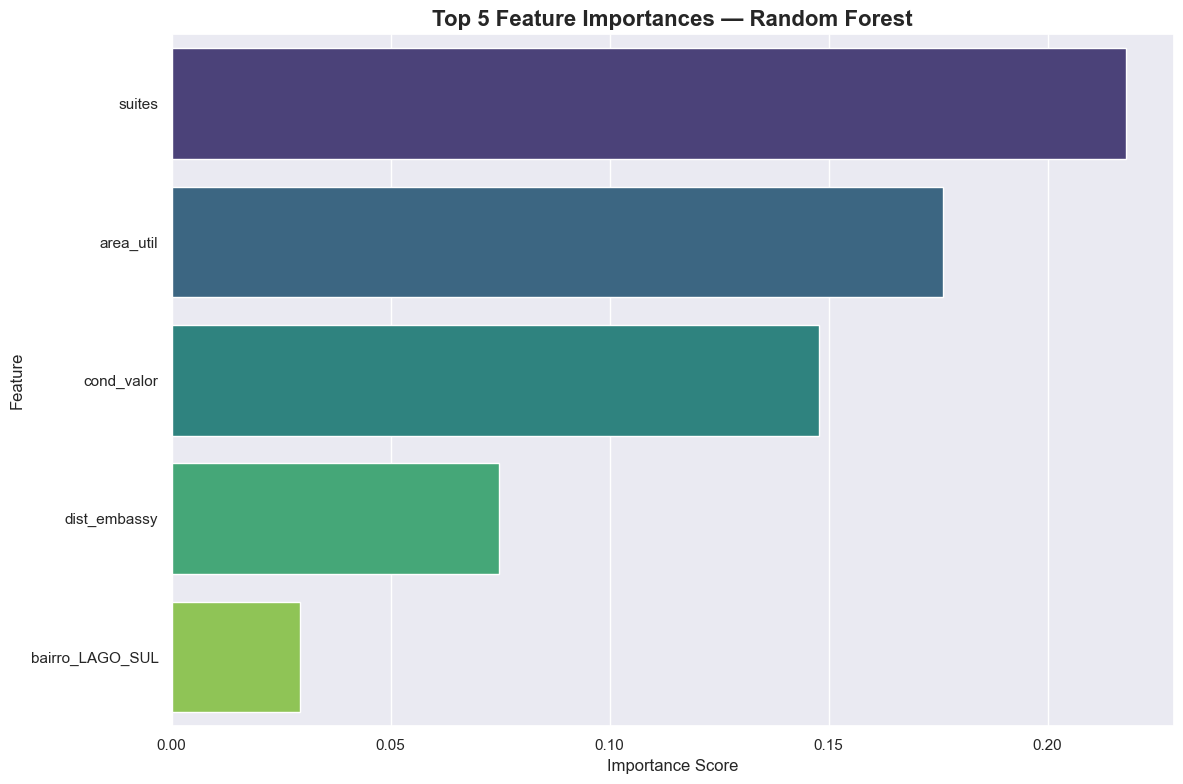


📁 Feature importance plot saved to: MODEL_RESULTS//randomforest_feature_importances_with_POIS.png


In [19]:
# ============================================================
# 2️⃣ FEATURE IMPORTANCE PLOT — Correct Sorted Order
# ============================================================
import seaborn as sns
import matplotlib.pyplot as plt

output_path = f"{OUTPUT_DIR_MODELS}/randomforest_feature_importances_with_POIS.png"

top_n = 5

# 0️⃣ garantir tipo numérico
importances["importance"] = importances["importance"].astype(float)

# 1️⃣ ordenar do MAIOR → MENOR
top_feats = (
    importances
    .sort_values("importance", ascending=False)
    .head(top_n)
    .copy()
)

# 2️⃣ Ordem explícita **mantida exatamente igual**
order_features = top_feats["feature"].tolist()

plt.figure(figsize=(12, 8))

sns.barplot(
    data=top_feats,
    x="importance",
    y="feature",
    palette="viridis",
    order=order_features,   # <— preserva a ordem MAIOR → MENOR
    legend=False,
    hue="feature",

)

plt.title(f"Top {top_n} Feature Importances — Random Forest",
          fontsize=16, fontweight="bold")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"\n📁 Feature importance plot saved to: {output_path}")



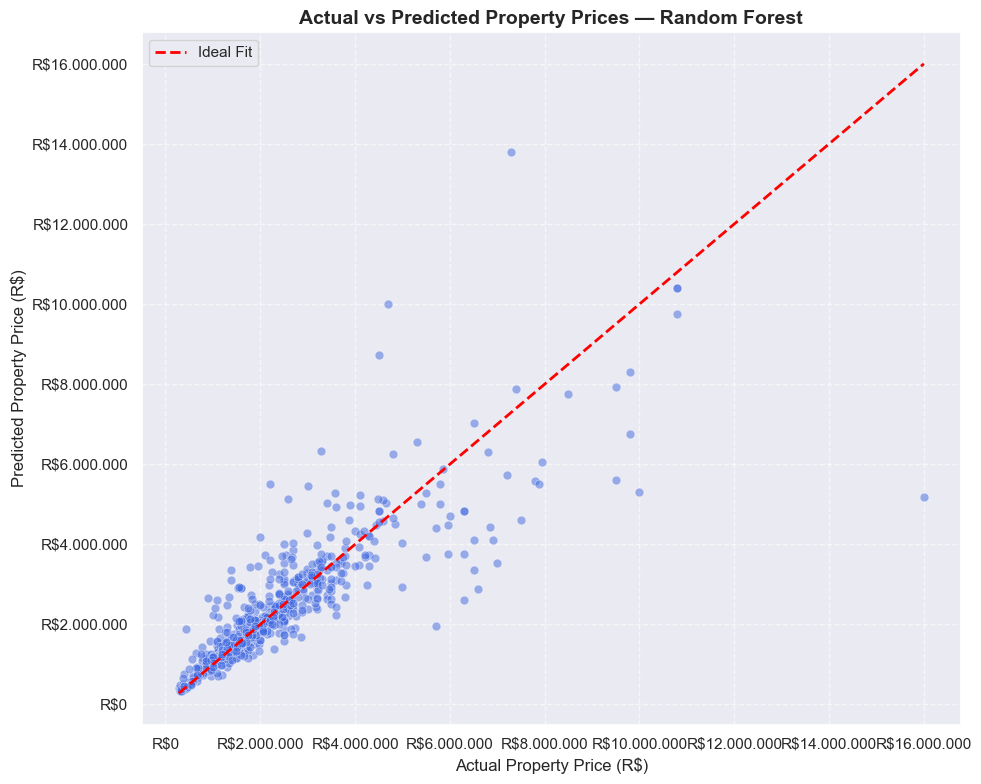

📁 Plot saved to: MODEL_RESULTS//randomforest_actual_vs_predicted_with_POIS.png


In [20]:
# ======================================================
# 📊 ACTUAL VS PREDICTED PLOT — RANDOM FOREST MODEL
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# ------------------------------------------------------
# 1️⃣ Scatter Plot — Actual vs Predicted
# ------------------------------------------------------

plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=y_test,
    y=y_pred,
    alpha=0.5,
    color="royalblue",
    s=40
)

# ------------------------------------------------------
# 2️⃣ Ideal Reference Line (y = x)
# ------------------------------------------------------

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Ideal Fit"
)

# ------------------------------------------------------
# 3️⃣ Titles and Labels
# ------------------------------------------------------

plt.title("Actual vs Predicted Property Prices — Random Forest", fontsize=14, fontweight="bold")
plt.xlabel("Actual Property Price (R$)", fontsize=12)
plt.ylabel("Predicted Property Price (R$)", fontsize=12)

# ------------------------------------------------------
# 4️⃣ Axis Formatting (Brazilian Real Currency)
# ------------------------------------------------------

real_formatter = FuncFormatter(lambda x, _: f"R${x:,.0f}".replace(",", "."))
plt.gca().xaxis.set_major_formatter(real_formatter)
plt.gca().yaxis.set_major_formatter(real_formatter)

# ------------------------------------------------------
# 5️⃣ Grid and Layout
# ------------------------------------------------------

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# ------------------------------------------------------
# 6️⃣ Save Figure
# ------------------------------------------------------

output_path = f"{OUTPUT_DIR_MODELS}/randomforest_actual_vs_predicted_with_POIS.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()

print(f"📁 Plot saved to: {output_path}")


---

## 🧭 **Analysis of Models with Aggregated Geospatial Variables (POIs)**

The incorporation of geospatial variables — represented by distances to different **Points of Interest (POIs)** — brought significant changes to the behavior of the models, both from an explanatory perspective (OLS) and a predictive one (Random Forest).

### 🧩 **1. Multiple Linear Regression (OLS) with POIs**

#### 📌 **Substantial increase in explanatory power**

With the addition of POIs, the OLS model achieved:

* **R² = 0.640**
* **Adjusted R² = 0.618**

This represents a very significant improvement compared to versions without POIs.

#### 📌 **Main findings**

The model began capturing:

✔️ *Internal structural effects* (suites, parking spaces, usable area)
✔️ *Direct locational effects* (neighborhood attributes, local surroundings)
✔️ *Accessibility effects* (distance to hospitals, shops, parks, churches, services, etc.)

#### ⚠️ **Observed limitations**

Despite the increase in R², important structural issues arise:

* **Extreme multicollinearity** (Condition Number ≈ 1e+16)
* Several POIs highly correlated with one another
* Instability in coefficient estimates
* Presence of **inconsistent p-values**, indicating difficulty in distinguishing similar effects
* Residuals remain non-normal (high skewness and kurtosis)

#### 📌 **Conclusion on OLS**

The inclusion of POIs improves the model’s explanatory capacity, but **does not resolve the structural issues inherent to linear regression** in multicollinear settings.
Even so, the model provides valuable insights about the individual influence of variables and POIs.

---

### 🌲 **2. Random Forest Regressor with POIs**

After including distances to POIs, the Random Forest model produced:

* **MAE  : 408,722.81**
* **RMSE : 864,508.05**
* **R²   : 0.7219**

These results are again **superior to the linear models**, confirming the robustness of non-linear approaches.

#### 📌 **Most important variables**

🏠 **Internal features:**

* suites
* usable area
* parking spaces

🌍 **Location — Neighborhoods:**

* bairro_LAGO_SUL

📏 **Distances to relevant POIs:**

* dist_embassy
* dist_christian_lutheran
* dist_fountain
* dist_residential
* dist_theatre

#### 📌 **Why does Random Forest improve with POIs?**

Because it:

* captures **non-linear relationships**
* is less sensitive to **multicollinearity**
* can leverage groups of variables with similar meaning (e.g., several types of commercial POIs)
* identifies complex interactions between internal structure + location

#### 📌 **Conclusion on the Random Forest**

Adding POIs further increased the model’s performance, reinforcing the importance of the geospatial dimension for predicting real estate prices — answering the second question of the project.

---

### 🆚 **3. Final Comparison Between Models With POIs**

| Model                 | Before             | After                   | Impact of POIs                                                               |
| --------------------- | ------------------ | ----------------------- | ---------------------------------------------------------------------------- |
| **Simple Regression** | Weak, insufficient | Not calculated          | —                                                                            |
| **OLS**               | R² ~0.34           | **R² = 0.64**           | 🚀 Large explanatory jump, but multicollinearity prevents reliable inference |
| **Random Forest**     | R² = 0.70          | **R² = 0.722**<br>MAE ↓ | 🎯 Consistent predictive improvement; model benefits from spatial data       |

---

## 🟦 **Conclusion — Answering the Fundamental Questions**

### ❓ *Does a property's price depend only on its physical characteristics (size, rooms, etc.)?*

### ✔️ **Answer: No.**

The models show that:

* Internal attributes matter (usable area, suites, parking spaces),
  **but explain only part of price variation**.

---

### ❓ *Does geographic location play a significant role in determining property value?*

### ✔️ **Answer: Yes — and very strongly.**

After including POIs:

* OLS doubled its R².
* Random Forest improved accuracy and reduced error.
* Variables such as proximity to embassies, theaters, residential areas, and urban services became highly relevant.
* High-end neighborhoods like Lago Sul emerged as highly influential.

📌 **This demonstrates that location is one of the main pillars of real estate pricing.**

---

### ❓ *Can the presence of nearby amenities (parks, malls, schools, hospitals, etc.) increase property value?*

### ✔️ **Answer: Yes — and this was clearly demonstrated.**

Distances to many POIs proved important:

* Essential services (pharmacies, supermarkets, hospitals)
* Urban facilities (theaters, libraries)
* Cultural and touristic sites
* Green areas
* Institutional structures (embassies, police stations)
* Everyday services (bakeries, gyms, commerce)

The **closer** the property is to relevant amenities, the **higher** its value tends to be.
The Random Forest highlighted this clearly, placing several POIs among the most important variables.

---

## 📌 Personal Impressions

At this point, the conclusion becomes obvious to anyone living in Brasília: **location strongly influences property values**, and the models make this abundantly clear.

Areas near **embassies**, for example, are traditionally recognized as premium zones in major capitals — and Brasília is no exception.

Regarding **urban amenities**, the Federal District is particularly well equipped: hospitals, schools, green areas, commerce, transportation, and public services are relatively well distributed between central and peripheral regions.
What changes, in practice, is the **consumption level** and **quality of establishments** — more expensive in wealthy areas, more affordable elsewhere.

**Lago Sul** stands out as a highly valued district, due to its proximity to the Plano Piloto and its urban design featuring large lots, spacious houses, and upscale condominiums. This contrasts with the Plano Piloto, known for its high supply of apartments and vertical buildings.

Overall, Brasília has a much better infrastructure than most Brazilian states, especially regarding hospitals, public services, mobility, and urban equipment. For this reason, factors like “proximity to a hospital” or “access to transportation” end up not being major differentiators in price formation — because **the entire city is relatively well served**.

In such cases, what more strongly determines value is the **size**, **construction standard**, and **socioeconomic profile of the neighborhood**.

Another important point is **multicollinearity**. From the beginning, we knew it would be present — after all, many variables are strongly correlated with one another, such as `usable_area` and number of `suites`.
This makes sense: larger properties tend to have more suites, which naturally affects price.

Even so, despite the collinearity, we were able to extract **coherent and valuable insights**, provided we interpret everything within the urban and real estate context.

What I want to emphasize is that at no point did we lose sight of the central questions guiding the project:

* **Does a property’s price depend solely on its physical characteristics?**
* **Does geographic location significantly influence value?**
* **Do nearby amenities such as parks, schools, and services impact appreciation?**

After all the analysis — models, exploration, statistics, and validation — the answer is clear:
**Yes, we fully answered all these questions.**

And here’s a crucial point for any analyst:
👉 **Every analytical process must be anchored in a well-defined question.**
It is the question that guides the investigation, prevents dispersion, and keeps the focus on concrete results.
Without it, one risks getting lost in an endless sea of hypotheses, correlations, and possibilities that naturally arise throughout exploratory data analysis.

---

In [21]:
end_time = time.time()
total_seconds = end_time - start_time

hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

print(f"⏳ Total execution time: {hours:.0f}h {minutes:.0f}m {seconds:.2f}s")

⏳ Total execution time: 0h 3m 26.54s
